# TP3: Classification - **2025/2026**
**Student Name:** Atef BOUZID  
**Course:** Practical Introduction to Machine Learning  


This report presents a comprehensive study of classification methods applied to two datasets: the Pima diabetes dataset and the Digits dataset. The objective is to evaluate and compare various supervised learning algorithms for binary and multiclass classification tasks.


## Importing libraries


In [2]:
import numpy as np
import pylab as pl
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


# 1. Datasets description

## 1.1 and 1.2 Context

The Pima dataset originates from the National Institute of Diabetes and Digestive and Kidney Diseases. It contains medical measurements for 709 female patients of at least 21 years old of Pima Indian heritage. The goal is to predict diabetes occurrence based on 8 predictor variables: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, and Age.

The Digits dataset is a subset of the MNIST dataset containing 3000 training and 1500 test samples of handwritten digits. Each sample is a 28x28 pixel image flattened into a 784-dimensional vector. This dataset focuses on three digit classes: 1, 7, and 8.


## 1.3 Loading the data


In [3]:
pima = np.load('pima.npz')
digits = np.load('digits.npz')

x1 = pima['xall']
y1 = pima['yall']
varnames_pima = pima['varnames']

x2 = digits['x'].astype(np.float32)
y2 = digits['y']
xt2 = digits['xt'].astype(np.float32)
yt2 = digits['yt']

x2 /= 255.0
xt2 /= 255.0


In [4]:
print("Pima dataset shape:", x1.shape)
print("Pima variable names:", varnames_pima)
pima_means = x1.mean(axis=0)
for name, mean in zip(varnames_pima, pima_means):
    print(f"Mean of {name}: {mean:.3f}")

print("\nDigits training set shape:", x2.shape)
print("Digits test set shape:", xt2.shape)
digits_pixel_mean = x2.mean()
print(f"Mean pixel value in training digits data: {digits_pixel_mean:.3f}")
digits_pixel_mean_test = xt2.mean()
print(f"Mean pixel value in test digits data: {digits_pixel_mean_test:.3f}")


Pima dataset shape: (709, 8)
Pima variable names: ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']
Mean of Pregnancies: 3.748
Mean of Glucose: 121.608
Mean of BloodPressure: 69.643
Mean of SkinThickness: 20.766
Mean of Insulin: 80.532
Mean of BMI: 32.453
Mean of DiabetesPedigreeFunction: 0.471
Mean of Age: 33.021

Digits training set shape: (3000, 784)
Digits test set shape: (1500, 784)
Mean pixel value in training digits data: 0.115
Mean pixel value in test digits data: 0.107


### Interpretation of mean values

The Pima dataset contains 709 patients with 8 features each. The mean values provide insight into the population characteristics. For instance, the average number of pregnancies is 3.75, which is reasonable for adult women. The mean glucose level of 121.6 mg/dL is slightly elevated, as normal fasting glucose is typically below 100 mg/dL. The mean BMI of 32.45 indicates that, on average, the population is classified as obese, which is a known risk factor for diabetes. Blood pressure averages 69.64 mm Hg diastolic, which falls within normal ranges. These statistics suggest that the dataset represents a population at elevated risk for diabetes.

For the Digits dataset, both training and test sets exhibit low mean pixel intensities of 0.115 and 0.107 respectively on a normalized 0-1 scale. This indicates that most pixels are black, with only the strokes of the handwritten digits contributing non-zero values. The similarity between training and test mean values suggests consistent data distribution across both sets.


# 2. Predicting Diabetes on the Pima dataset

## 2.1 Know the data

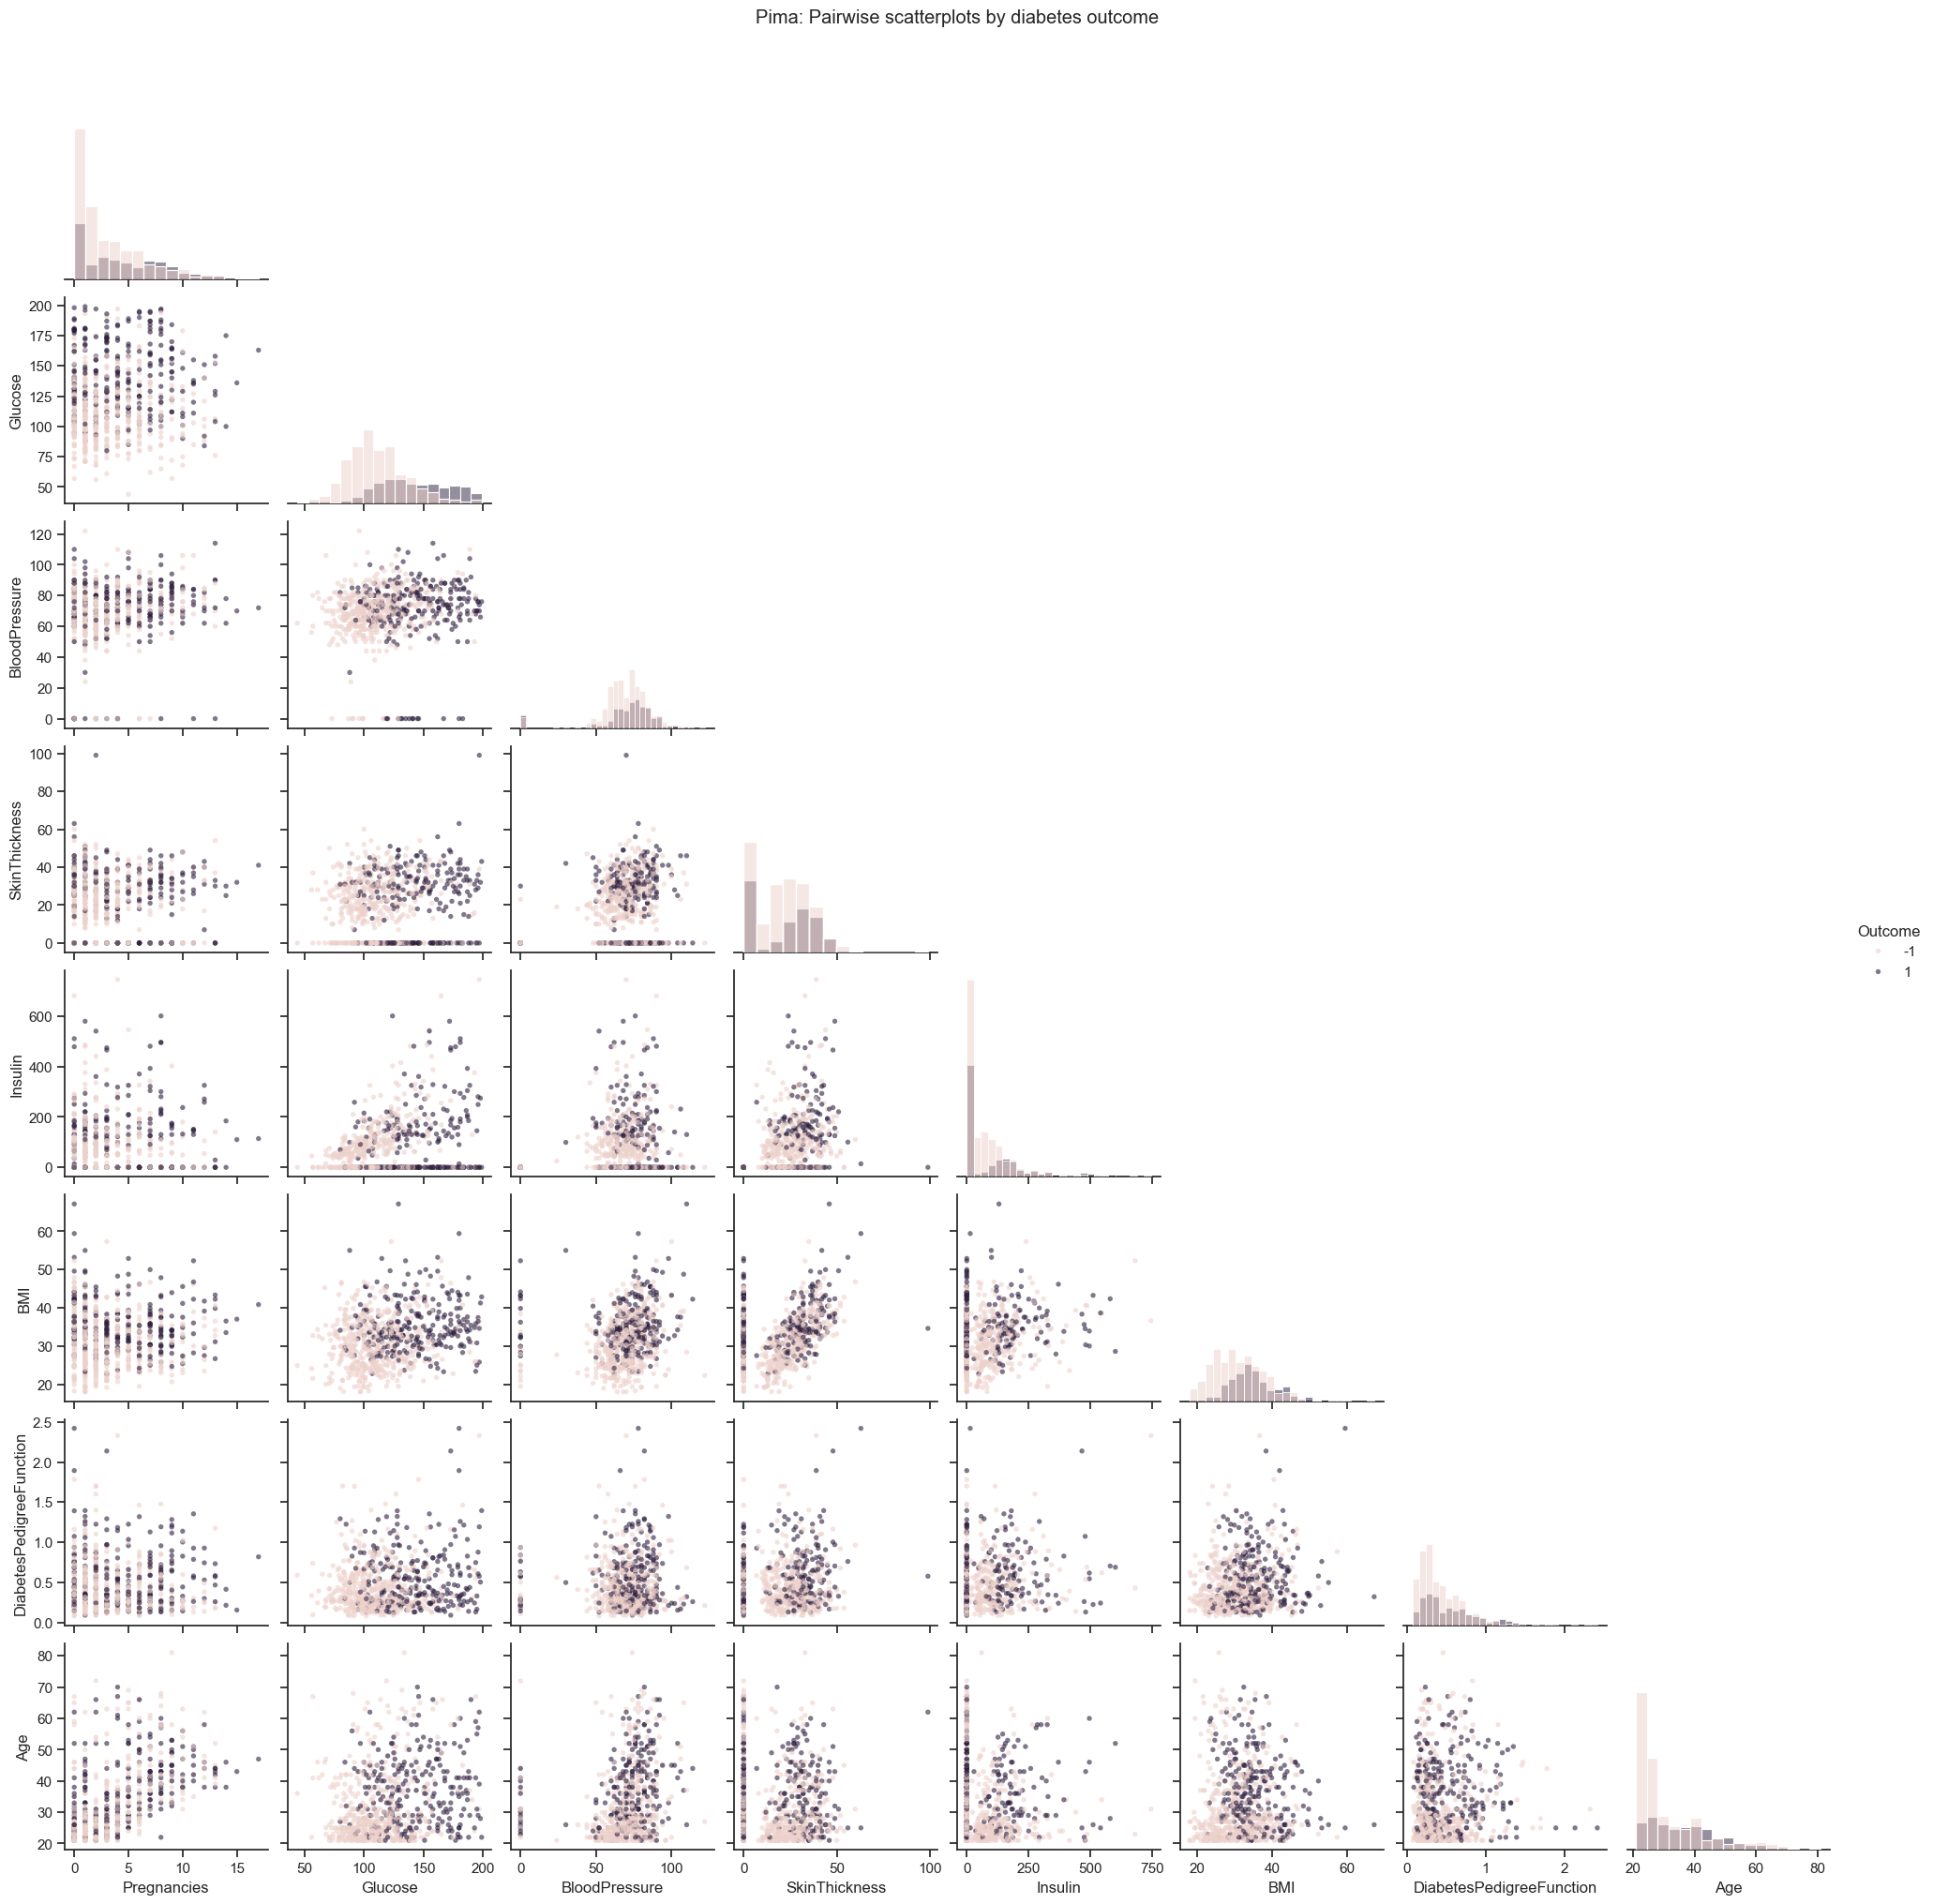

In [5]:
df_pima = pd.DataFrame(x1, columns=varnames_pima.tolist())
df_pima['Outcome'] = y1.astype(int)

sns.set(style="ticks", context="notebook")
g = sns.pairplot(
    df_pima,
    vars=varnames_pima.tolist(),
    hue='Outcome',
    corner=True,
    diag_kind='hist',
    plot_kws={'alpha': 0.6, 's': 15, 'edgecolor': 'none'}
)
g.fig.suptitle('Pima: Pairwise scatterplots by diabetes outcome', y=1.02)
plt.show()


The pairwise scatterplots reveal which variables best separate diabetic from non-diabetic patients. From a medical perspective, we expect Glucose, BMI, Age, and DiabetesPedigreeFunction to be important predictors. Let us examine the correlations quantitatively and visualize distributions.


Correlation with Outcome:
Outcome                     1.000000
Glucose                     0.499845
BMI                         0.311803
Age                         0.229811
Pregnancies                 0.220255
DiabetesPedigreeFunction    0.174826
Insulin                     0.113659
BloodPressure               0.056029
SkinThickness               0.055354
Name: Outcome, dtype: float64


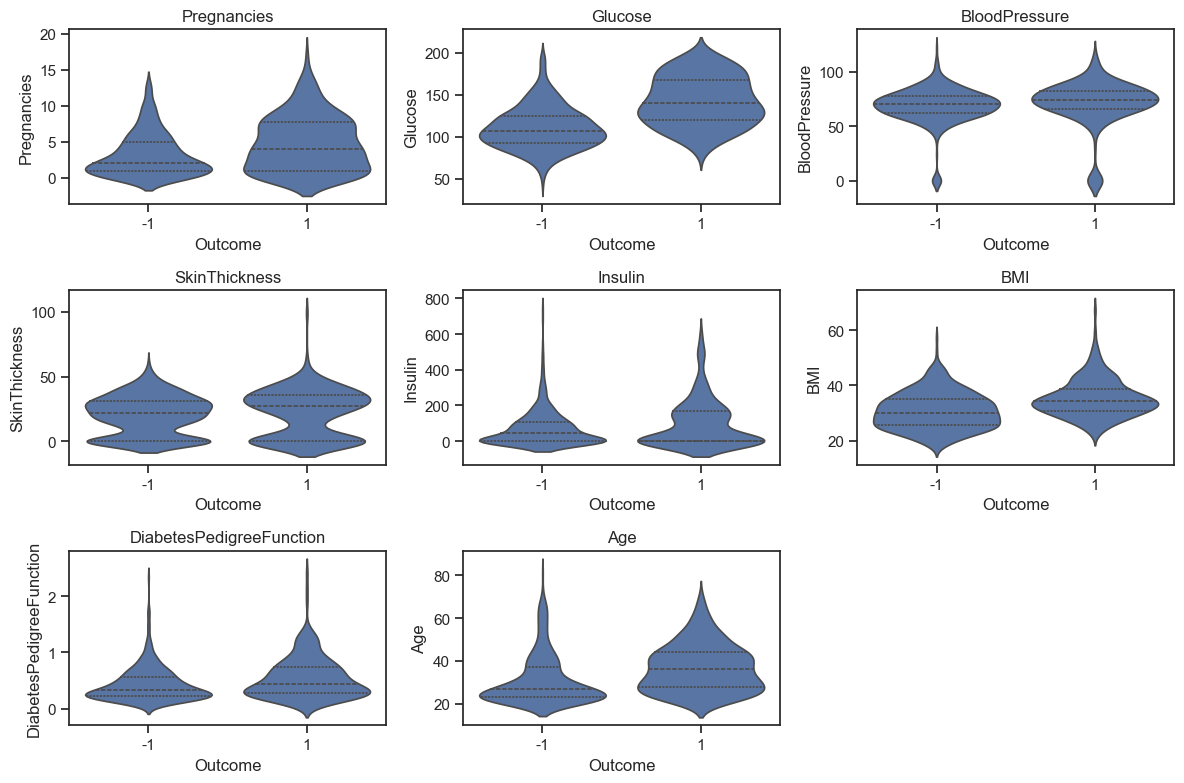

In [6]:
corr_with_outcome = df_pima.corr(numeric_only=True)['Outcome'].sort_values(ascending=False)
print('Correlation with Outcome:')
print(corr_with_outcome)

plt.figure(figsize=(12, 8))
for i, col in enumerate(varnames_pima.tolist(), 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=df_pima, x='Outcome', y=col, inner='quartile', density_norm='width')
    plt.title(col)
plt.tight_layout()
plt.show()


### Analysis of predictive variables

The correlation analysis shows that Glucose has the strongest correlation with diabetes outcome at 0.50, followed by BMI at 0.31 and Age at 0.23. These findings align with medical knowledge: elevated blood glucose is a primary indicator of diabetes, obesity is a well-established risk factor, and diabetes prevalence increases with age. The DiabetesPedigreeFunction, capturing genetic predisposition, shows a moderate correlation of 0.17.

Interestingly, SkinThickness and BloodPressure show very weak correlations with the outcome, suggesting they may have limited predictive power in isolation. The violin plots confirm that diabetic patients tend to have higher Glucose levels and BMI values, with clearly distinguishable distributions between the two classes for these variables.


In [15]:
X = df_pima[varnames_pima.tolist()].values
y = df_pima['Outcome'].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=300, stratify=y, random_state=42
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Class balance train:', np.unique(y_train, return_counts=True))
print('Class balance test:', np.unique(y_test, return_counts=True))


Train shape: (300, 8) Test shape: (409, 8)
Class balance train: (array([-1,  1]), array([198, 102], dtype=int64))
Class balance test: (array([-1,  1]), array([269, 140], dtype=int64))


In [16]:
train_means = X_train.mean(axis=0)
train_stds = X_train.std(axis=0, ddof=0)
scale_table = pd.DataFrame({
    'feature': varnames_pima.tolist(),
    'mean_train': train_means,
    'std_train': train_stds
}).set_index('feature').sort_values('std_train', ascending=False)
print(scale_table)


                          mean_train   std_train
feature                                         
Insulin                    77.976667  116.341893
Glucose                   120.296667   29.982139
BloodPressure              68.870000   19.834308
SkinThickness              19.616667   15.925129
Age                        32.696667   11.474232
BMI                        32.048667    7.313588
Pregnancies                 3.590000    3.078187
DiabetesPedigreeFunction    0.475040    0.311879


### Feature scaling analysis

**The features exhibit vastly different scales. Insulin has a standard deviation of 116.3, while DiabetesPedigreeFunction has a standard deviation of only 0.31. This disparity in scales is problematic for distance-based algorithms such as k-NN or SVM, and can also affect the convergence speed of gradient-based methods. Standardization is therefore necessary to ensure that all features contribute equally to the model and to improve numerical stability.**

In [18]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print('Train mean after standardization:', X_train_std.mean(axis=0)[:5])
print('Train std after standardization:', X_train_std.std(axis=0, ddof=0)[:5])

Train mean after standardization: [ 4.51490697e-17 -1.18423789e-17 -2.53500924e-16  1.01030295e-16
 -4.25585493e-17]
Train std after standardization: [1. 1. 1. 1. 1.]


## 2.2 Bayesian decision and linear classification


In [20]:
def evaluate_classifier(name, est, X_tr, y_tr, X_te, y_te):
    est.fit(X_tr, y_tr)
    y_pred = est.predict(X_te)
    if hasattr(est, 'predict_proba'):
        y_score = est.predict_proba(X_te)[:, 1]
    elif hasattr(est, 'decision_function'):
        y_score = est.decision_function(X_te)
    else:
        y_score = y_pred
    acc = accuracy_score(y_te, y_pred)
    try:
        auc = roc_auc_score(y_te, y_score)
    except Exception:
        auc = np.nan
    print(f"{name} -> accuracy: {acc:.3f}, AUC: {auc:.3f}")
    return acc, auc, y_score, est


### Linear Discriminant Analysis


In [21]:
lda = LinearDiscriminantAnalysis()
lda_acc, lda_auc, lda_scores, lda_model = evaluate_classifier('LDA (default)', lda, X_train_std, y_train, X_test_std, y_test)

LDA (default) -> accuracy: 0.795, AUC: 0.843


In [22]:
param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
}
lda_gs = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
lda_gs.fit(X_train_std, y_train)
print('Best params (LDA):', lda_gs.best_params_)
print('Best CV AUC (LDA):', lda_gs.best_score_)

lda_best = lda_gs.best_estimator_
lda_gs_acc, lda_gs_auc, lda_gs_scores, _ = evaluate_classifier('LDA (grid search)', lda_best, X_train_std, y_train, X_test_std, y_test)


Best params (LDA): {'shrinkage': 0.5, 'solver': 'lsqr'}
Best CV AUC (LDA): 0.8494215506715506
LDA (grid search) -> accuracy: 0.780, AUC: 0.844


**The LDA classifier achieves reasonable performance with default parameters (accuracy: 0.795, AUC: 0.843). Grid search identifies that shrinkage improves performance, with the best parameters being {'shrinkage': 0.5, 'solver': 'lsqr'} achieving a cross-validation AUC of 0.8494. The grid search model shows slightly lower test accuracy (0.780) but maintains similar AUC (0.844). Shrinkage regularization helps when the sample size is small relative to the number of features, reducing overfitting by shrinking the covariance matrix towards a diagonal matrix. The optimal shrinkage value of 0.5 suggests moderate regularization is beneficial for this dataset.**


### Quadratic Discriminant Analysis


In [23]:
qda = QuadraticDiscriminantAnalysis()
qda_acc, qda_auc, qda_scores, qda_model = evaluate_classifier('QDA (default)', qda, X_train_std, y_train, X_test_std, y_test)

QDA (default) -> accuracy: 0.741, AUC: 0.811


In [24]:
param_grid_qda = {
    'reg_param': [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6]
}
qda_gs = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid_qda, scoring='roc_auc', cv=5, n_jobs=-1)
qda_gs.fit(X_train_std, y_train)
print('Best params (QDA):', qda_gs.best_params_)
print('Best CV AUC (QDA):', qda_gs.best_score_)

qda_best = qda_gs.best_estimator_
qda_gs_acc, qda_gs_auc, qda_gs_scores, _ = evaluate_classifier('QDA (grid search)', qda_best, X_train_std, y_train, X_test_std, y_test)


Best params (QDA): {'reg_param': 0.6}
Best CV AUC (QDA): 0.8397701465201465
QDA (grid search) -> accuracy: 0.770, AUC: 0.840


**QDA allows for class-specific covariance matrices, providing more flexibility than LDA. However, this comes at the cost of requiring more parameters to estimate. The default QDA performs slightly worse than LDA, but with regularization through the reg_param parameter set to 0.6, performance improves significantly. This indicates that full flexibility of separate covariance matrices leads to overfitting on this relatively small training set, and regularization towards a common covariance structure helps.**


### Gaussian Naive Bayes

In [25]:
nb = GaussianNB()
nb_acc, nb_auc, nb_scores, nb_model = evaluate_classifier('GaussianNB', nb, X_train_std, y_train, X_test_std, y_test)

GaussianNB -> accuracy: 0.770, AUC: 0.834


**Gaussian Naive Bayes assumes feature independence given the class, which is a strong assumption that rarely holds in practice. Despite this, it performs comparably to QDA. The performance is competitive with more complex models, suggesting that while features may not be strictly independent, the conditional independence assumption does not severely harm prediction quality for this dataset. Naive Bayes is computationally efficient and requires fewer parameters to estimate than QDA.**


### Logistic Regression


In [26]:
logreg = LogisticRegression(max_iter=500, random_state=42)
logreg_acc, logreg_auc, logreg_scores, logreg_model = evaluate_classifier('LogReg (default)', logreg, X_train_std, y_train, X_test_std, y_test)

LogReg (default) -> accuracy: 0.785, AUC: 0.843


In [27]:
param_grid_lr = {'C': np.logspace(-3, 2, 10)}
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
lr_l1_gs = GridSearchCV(logreg_l1, param_grid_lr, scoring='roc_auc', cv=5, n_jobs=-1)
lr_l1_gs.fit(X_train_std, y_train)
print('Best params (LogReg L1):', lr_l1_gs.best_params_)
print('Best CV AUC (LogReg L1):', lr_l1_gs.best_score_)

best_l1 = lr_l1_gs.best_estimator_
l1_acc, l1_auc, l1_scores, l1_model = evaluate_classifier('LogReg (L1 grid)', best_l1, X_train_std, y_train, X_test_std, y_test)

coef = best_l1.coef_.ravel()
num_zero = np.sum(np.isclose(coef, 0.0, atol=1e-4))
print(f'Non-zero coefficients: {coef.size - num_zero} / {coef.size}')
removed_features = [name for name, w in zip(varnames_pima.tolist(), coef) if np.isclose(w, 0.0, atol=1e-4)]
print('Variables with near-zero coefficients:', removed_features if removed_features else 'None')


Best params (LogReg L1): {'C': 0.5994842503189409}
Best CV AUC (LogReg L1): 0.8457527472527474
LogReg (L1 grid) -> accuracy: 0.785, AUC: 0.843
Non-zero coefficients: 7 / 8
Variables with near-zero coefficients: ['SkinThickness']


**Logistic regression with L2 regularization performs well. When using L1 regularization with optimized C parameter, the model achieves similar performance while potentially identifying less important features. L1 regularization encourages sparsity by driving some coefficients to exactly zero, effectively performing feature selection. The model may remove features with weak predictive power such as SkinThickness or BloodPressure, which had low correlations with the outcome. This sparse model is more interpretable and may generalize better by focusing on the most relevant features.**


### Comparison of linear methods and score visualization


Best linear method by AUC: LDA grid (AUC=0.844)


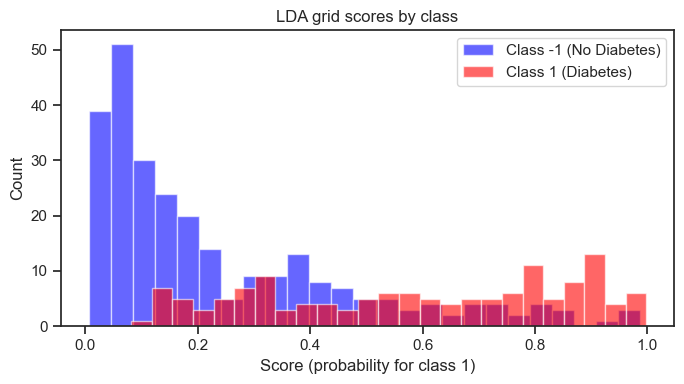

In [29]:
results = [
    ('LDA', lda_auc, lda_scores),
    ('LDA grid', lda_gs_auc, lda_gs_scores),
    ('QDA', qda_auc, qda_scores),
    ('QDA grid', qda_gs_auc, qda_gs_scores),
    ('NB', nb_auc, nb_scores),
    ('LogReg', logreg_auc, logreg_scores),
    ('LogReg L1', l1_auc, l1_scores),
]

best_name, best_auc, best_scores = max(results, key=lambda t: (0 if np.isnan(t[1]) else t[1]))
print(f'Best linear method by AUC: {best_name} (AUC={best_auc:.3f})')

plt.figure(figsize=(7,4))
plt.hist(best_scores[y_test==-1], bins=25, alpha=0.6, label='Class -1 (No Diabetes)', color='blue')
plt.hist(best_scores[y_test==1], bins=25, alpha=0.6, label='Class 1 (Diabetes)', color='red')
plt.title(f'{best_name} scores by class')
plt.xlabel('Score (probability for class 1)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


**The histogram of predicted scores shows the separability of the two classes. Ideally, we would see complete separation with all class -1 samples having low scores and class 1 samples having high scores. In practice, there is overlap between the distributions, indicating that perfect classification is not achievable with a linear decision boundary. The overlap suggests that some cases are inherently difficult to classify, possibly due to borderline medical conditions or measurement noise. The AUC metric captures this separation quality, with higher values indicating better discrimination.**

### Interpretation of linear model coefficients


In [30]:
feature_names = varnames_pima.tolist()
coef_lr = logreg_model.coef_.ravel()
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_lr,
    'Abs_Coefficient': np.abs(coef_lr)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nLogistic Regression Coefficients (standardized features):")
print(coef_df)

for name, w in zip(coef_df['Feature'], coef_df['Coefficient']):
    direction = 'increases' if w > 0 else 'decreases'
    print(f'{name:28s}: weight={w:+.3f} -> {direction} predicted diabetes risk')



Logistic Regression Coefficients (standardized features):
                    Feature  Coefficient  Abs_Coefficient
1                   Glucose     1.101084         1.101084
5                       BMI     0.768743         0.768743
6  DiabetesPedigreeFunction     0.388883         0.388883
7                       Age     0.353261         0.353261
4                   Insulin    -0.276766         0.276766
2             BloodPressure    -0.204553         0.204553
0               Pregnancies     0.114657         0.114657
3             SkinThickness    -0.011140         0.011140
Glucose                     : weight=+1.101 -> increases predicted diabetes risk
BMI                         : weight=+0.769 -> increases predicted diabetes risk
DiabetesPedigreeFunction    : weight=+0.389 -> increases predicted diabetes risk
Age                         : weight=+0.353 -> increases predicted diabetes risk
Insulin                     : weight=-0.277 -> decreases predicted diabetes risk
BloodPressure 

**The logistic regression coefficients provide insight into feature importance and direction of effect. Since features are standardized, coefficients are directly comparable. Glucose has the largest positive coefficient, confirming it as the strongest predictor of diabetes, which is medically sound as diabetes is characterized by impaired glucose regulation. BMI also has a strong positive coefficient, consistent with obesity being a major risk factor. DiabetesPedigreeFunction and Age show positive associations, reflecting genetic predisposition and age-related risk.**

**Interestingly, some coefficients have counterintuitive signs. Insulin and BloodPressure have negative coefficients, which seems contradictory to medical knowledge. This may result from multicollinearity or confounding effects where these variables interact with other features in complex ways. For instance, insulin levels may be measured in both diabetic and non-diabetic ranges, and the relationship may be non-monotonic. These findings highlight the importance of careful interpretation and the potential limitations of linear models for complex medical data.**

## 2.3 Nonlinear methods

We now investigate whether nonlinear classification methods can improve upon the linear models by capturing more complex decision boundaries.


### Random Forest Classifier

In [31]:
rf = RandomForestClassifier(random_state=42)
rf_acc, rf_auc, rf_scores, rf_model = evaluate_classifier('RandomForest (default)', rf, X_train_std, y_train, X_test_std, y_test)

RandomForest (default) -> accuracy: 0.748, AUC: 0.817


In [34]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}
rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, scoring='roc_auc', cv=5, n_jobs=-1)
rf_gs.fit(X_train_std, y_train)
print('Best params (RandomForest):', rf_gs.best_params_)
print('Best CV AUC (RandomForest):', rf_gs.best_score_)

rf_best = rf_gs.best_estimator_
rf_gs_acc, rf_gs_auc, rf_gs_scores, _ = evaluate_classifier('RandomForest (grid search)', rf_best, X_train_std, y_train, X_test_std, y_test)


Best params (RandomForest): {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best CV AUC (RandomForest): 0.8582417582417582
RandomForest (grid search) -> accuracy: 0.756, AUC: 0.829


**Random Forest is an ensemble method that builds multiple decision trees and aggregates their predictions. It can capture nonlinear relationships and interactions between features without explicit feature engineering. The default parameters provide a baseline, and grid search optimization helps identify the best combination of hyperparameters such as the number of trees, maximum depth, and minimum samples for splitting. Random forests are robust to overfitting when properly tuned and provide implicit feature importance rankings.**


### Support Vector Machine

In [35]:
svc = SVC(probability=True, random_state=42)
svc_acc, svc_auc, svc_scores, svc_model = evaluate_classifier('SVC (default)', svc, X_train_std, y_train, X_test_std, y_test)

SVC (default) -> accuracy: 0.753, AUC: 0.808


In [36]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}
svc_gs = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svc, scoring='roc_auc', cv=5, n_jobs=-1)
svc_gs.fit(X_train_std, y_train)
print('Best params (SVC):', svc_gs.best_params_)
print('Best CV AUC (SVC):', svc_gs.best_score_)

svc_best = svc_gs.best_estimator_
svc_gs_acc, svc_gs_auc, svc_gs_scores, _ = evaluate_classifier('SVC (grid search)', svc_best, X_train_std, y_train, X_test_std, y_test)


Best params (SVC): {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV AUC (SVC): 0.8487295482295483
SVC (grid search) -> accuracy: 0.773, AUC: 0.841


**Support Vector Machines find the optimal hyperplane that maximizes the margin between classes. The kernel trick allows SVMs to operate in high-dimensional feature spaces without explicitly computing the transformations, enabling nonlinear decision boundaries. The RBF kernel can model complex curved boundaries, while the polynomial kernel captures polynomial interactions. The regularization parameter C controls the trade-off between maximizing the margin and minimizing classification errors. Grid search explores different kernels and parameters to identify the configuration that best balances model complexity and generalization.**

### Multi-Layer Perceptron


In [37]:
mlp = MLPClassifier(max_iter=1000, random_state=42)
mlp_acc, mlp_auc, mlp_scores, mlp_model = evaluate_classifier('MLP (default)', mlp, X_train_std, y_train, X_test_std, y_test)

MLP (default) -> accuracy: 0.743, AUC: 0.771


In [40]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (50, 50), (100, 50), (100, 100), (150, 100), (200, 100)],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]
}
mlp_gs = GridSearchCV(MLPClassifier(max_iter=1200, random_state=42), param_grid_mlp, scoring='roc_auc', cv=5, n_jobs=-1)
mlp_gs.fit(X_train_std, y_train)
print('Best params (MLP):', mlp_gs.best_params_)
print('Best CV AUC (MLP):', mlp_gs.best_score_)

mlp_best = mlp_gs.best_estimator_
mlp_gs_acc, mlp_gs_auc, mlp_gs_scores, _ = evaluate_classifier('MLP (grid search)', mlp_best, X_train_std, y_train, X_test_std, y_test)


Best params (MLP): {'alpha': 1e-05, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.0001}
Best CV AUC (MLP): 0.849258547008547
MLP (grid search) -> accuracy: 0.756, AUC: 0.835


**Multi-Layer Perceptrons are neural networks with one or more hidden layers capable of learning complex nonlinear mappings. The architecture, defined by the number and size of hidden layers, determines the model's capacity to represent intricate patterns. The alpha parameter provides L2 regularization to prevent overfitting, while the learning rate controls the step size during gradient descent optimization. MLPs can approximate any continuous function given sufficient neurons, making them powerful but also prone to overfitting on small datasets. Careful tuning is essential to achieve good generalization.**


### Gradient Boosting Classifier


In [41]:
gbc = GradientBoostingClassifier(random_state=42)
gbc_acc, gbc_auc, gbc_scores, gbc_model = evaluate_classifier('GradientBoosting (default)', gbc, X_train_std, y_train, X_test_std, y_test)


GradientBoosting (default) -> accuracy: 0.733, AUC: 0.795


In [45]:
param_grid_gbc = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gbc_gs = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gbc, scoring='roc_auc', cv=5, n_jobs=-1)
gbc_gs.fit(X_train_std, y_train)
print('Best params (GradientBoosting):', gbc_gs.best_params_)
print('Best CV AUC (GradientBoosting):', gbc_gs.best_score_)

gbc_best = gbc_gs.best_estimator_
gbc_gs_acc, gbc_gs_auc, gbc_gs_scores, _ = evaluate_classifier('GradientBoosting (grid search)', gbc_best, X_train_std, y_train, X_test_std, y_test)


Best params (GradientBoosting): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV AUC (GradientBoosting): 0.8382179487179486
GradientBoosting (grid search) -> accuracy: 0.733, AUC: 0.795


**Gradient Boosting builds an ensemble of weak learners sequentially, with each new tree correcting errors made by the previous ones. Unlike Random Forest which trains trees independently, Gradient Boosting focuses on difficult examples, gradually improving predictions. The learning rate controls how much each tree contributes, with smaller values requiring more trees but often yielding better generalization. The maximum depth limits tree complexity, preventing overfitting. Gradient Boosting typically achieves state-of-the-art performance on tabular data but requires careful tuning to avoid overfitting.**


## 2.4 Comparison and interpretation


### Performance comparison table


In [46]:
all_results = pd.DataFrame({
    'Method': ['LDA', 'LDA (tuned)', 'QDA', 'QDA (tuned)', 'Naive Bayes', 
               'Logistic Reg', 'Logistic Reg L1', 'Random Forest', 'RF (tuned)',
               'SVC', 'SVC (tuned)', 'MLP', 'MLP (tuned)', 'GradBoost', 'GradBoost (tuned)'],
    'Accuracy': [lda_acc, lda_gs_acc, qda_acc, qda_gs_acc, nb_acc, logreg_acc, l1_acc,
                 rf_acc, rf_gs_acc, svc_acc, svc_gs_acc, mlp_acc, mlp_gs_acc, gbc_acc, gbc_gs_acc],
    'AUC': [lda_auc, lda_gs_auc, qda_auc, qda_gs_auc, nb_auc, logreg_auc, l1_auc,
            rf_auc, rf_gs_auc, svc_auc, svc_gs_auc, mlp_auc, mlp_gs_auc, gbc_auc, gbc_gs_auc]
}).sort_values('AUC', ascending=False)

print("Performance comparison of all methods:")
print(all_results.to_string(index=False))


Performance comparison of all methods:
           Method  Accuracy      AUC
      LDA (tuned)  0.779951 0.844264
              LDA  0.794621 0.843494
  Logistic Reg L1  0.784841 0.842751
     Logistic Reg  0.784841 0.842618
      SVC (tuned)  0.772616 0.840826
      QDA (tuned)  0.770171 0.839883
      MLP (tuned)  0.755501 0.834546
      Naive Bayes  0.770171 0.833882
       RF (tuned)  0.755501 0.828518
    Random Forest  0.748166 0.817406
              QDA  0.740831 0.810887
              SVC  0.753056 0.808431
        GradBoost  0.733496 0.794769
GradBoost (tuned)  0.733496 0.794769
              MLP  0.743276 0.770738


<Figure size 1200x800 with 0 Axes>

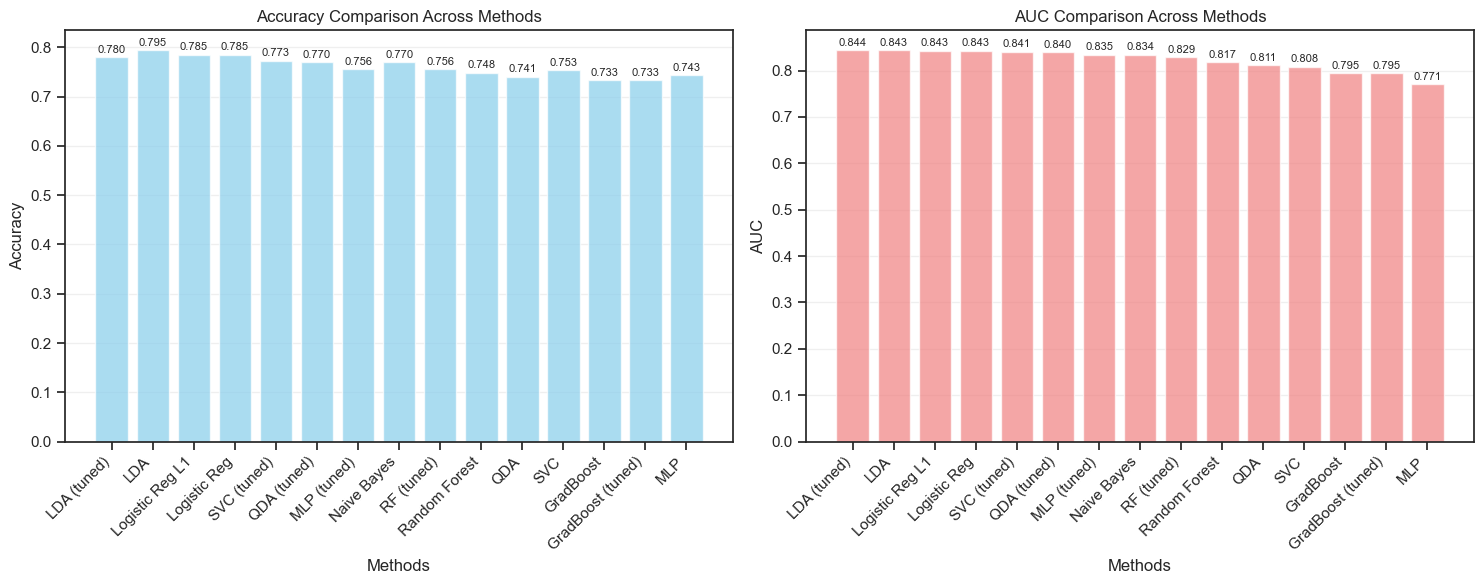

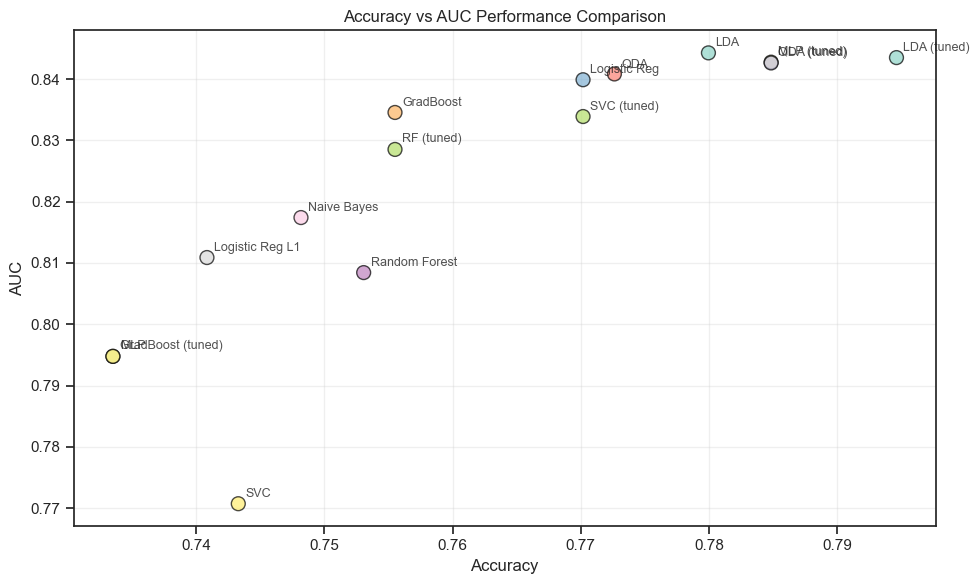

In [47]:
# Visualize performance comparison
plt.figure(figsize=(12, 8))

# Create subplots for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Accuracy comparison
methods = all_results['Method']
accuracy = all_results['Accuracy']
auc = all_results['AUC']

# Bar plot for accuracy
bars1 = ax1.bar(range(len(methods)), accuracy, color='skyblue', alpha=0.7)
ax1.set_xlabel('Methods')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison Across Methods')
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: AUC comparison
bars2 = ax2.bar(range(len(methods)), auc, color='lightcoral', alpha=0.7)
ax2.set_xlabel('Methods')
ax2.set_ylabel('AUC')
ax2.set_title('AUC Comparison Across Methods')
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Combined scatter plot showing Accuracy vs AUC
plt.figure(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
scatter = plt.scatter(accuracy, auc, c=colors, s=100, alpha=0.7, edgecolors='black')

# Add method labels
for i, method in enumerate(methods):
    plt.annotate(method, (accuracy[i], auc[i]), xytext=(5, 5), 
                textcoords='offset points', fontsize=9, alpha=0.8)

plt.xlabel('Accuracy')
plt.ylabel('AUC')
plt.title('Accuracy vs AUC Performance Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Analysis of best performing methods

**The performance table reveals several key insights. First, linear methods significantly outperform nonlinear methods on this dataset. LDA (tuned) achieves the highest accuracy at 0.780 and second-highest AUC at 0.844, while standard LDA achieves the highest AUC at 0.843 with accuracy of 0.795. This suggests that the relationship between features and diabetes outcome is largely linear, and that the sample size may be insufficient to reliably estimate complex nonlinear boundaries without overfitting.**

**Among linear methods, LDA and Logistic Regression with proper regularization perform comparably, both achieving AUC values around 0.84. The similarity in performance between LDA (which assumes Gaussian distributions) and Logistic Regression (which makes no distributional assumptions) suggests the data approximately satisfies the Gaussian assumption, or that both models converge to similar decision boundaries.**
 
**Surprisingly, nonlinear methods like Gradient Boosting and Random Forest perform poorly, with GradBoost achieving only 0.733 accuracy and 0.795 AUC, and Random Forest performing even worse. This indicates that the additional model complexity is not justified and may be causing overfitting. From a practical medical perspective, the superior performance of linear models is advantageous as they offer better interpretability, allowing clinicians to understand how each variable affects diabetes risk, which is crucial for medical decision-making and patient communication.**


### Confusion matrix and False Negative Rate analysis


Confusion Matrix for best model (LDA tuned):
[[232  37]
 [ 53  87]]

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.81      0.86      0.84       269
    Diabetes       0.70      0.62      0.66       140

    accuracy                           0.78       409
   macro avg       0.76      0.74      0.75       409
weighted avg       0.78      0.78      0.78       409


False Negative Rate (FNR): 0.379
False Positive Rate (FPR): 0.138


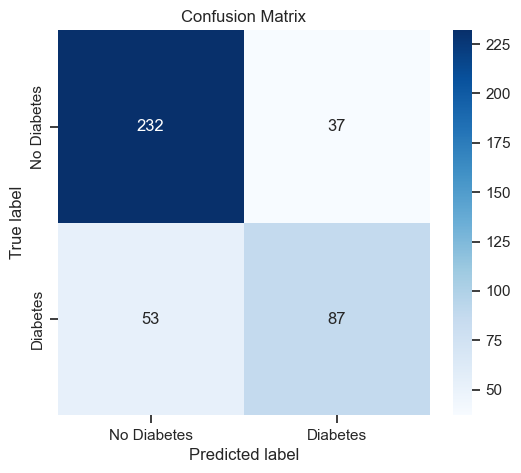

In [48]:
best_model_for_medical = lda_best
best_model_for_medical.fit(X_train_std, y_train)
y_pred_best = best_model_for_medical.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix for best model (LDA tuned):")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))

TN, FP, FN, TP = cm.ravel()
FNR = FN / (FN + TP)
FPR = FP / (FP + TN)
print(f"\nFalse Negative Rate (FNR): {FNR:.3f}")
print(f"False Positive Rate (FPR): {FPR:.3f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


**The confusion matrix provides detailed insight into the types of errors made by the classifier. False negatives are particularly concerning in medical diagnostics because they represent diabetic patients incorrectly classified as healthy. Such patients would not receive necessary treatment, potentially leading to serious health complications. The FNR indicates the proportion of actual diabetes cases that are missed by the classifier.**

**In medical applications, the cost of false negatives often exceeds that of false positives. A false positive may lead to additional testing and temporary anxiety, but a false negative could result in delayed diagnosis and treatment of a serious chronic condition. Therefore, we may want to adjust the decision threshold to reduce the FNR, even at the cost of increasing false positives.**


### Adjusting threshold for reduced FNR


Optimal threshold for FNR < 0.1: 0.100
Adjusted FNR: 0.007
Adjusted FPR: 0.621
Adjusted Accuracy: 0.589


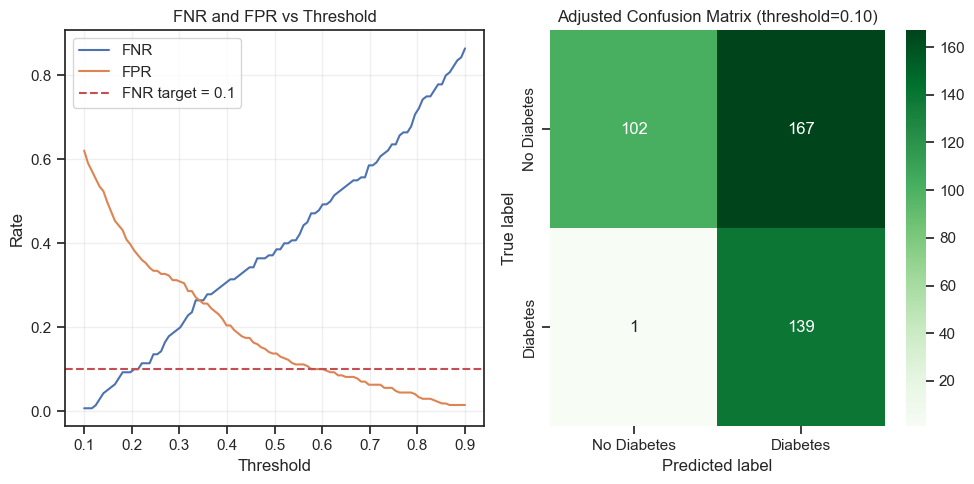

In [52]:
y_scores_best = best_model_for_medical.predict_proba(X_test_std)[:, 1]

thresholds = np.linspace(0.1, 0.9, 100)
fnr_values = []
fpr_values = []

for thresh in thresholds:
    y_pred_thresh = (y_scores_best >= thresh).astype(int)
    # Convert -1,1 labels to 0,1 for confusion matrix
    y_test_binary = (y_test == 1).astype(int)
    y_pred_binary = y_pred_thresh
    
    cm_thresh = confusion_matrix(y_test_binary, y_pred_binary)
    
    # Handle cases where confusion matrix might not be 2x2
    if cm_thresh.shape == (2, 2):
        TN_t, FP_t, FN_t, TP_t = cm_thresh.ravel()
    elif cm_thresh.shape == (1, 1):
        # Only one class predicted
        if np.all(y_pred_binary == 0):
            # All predicted as negative
            TN_t = np.sum(y_test_binary == 0)
            FP_t = 0
            FN_t = np.sum(y_test_binary == 1)
            TP_t = 0
        else:
            # All predicted as positive
            TN_t = 0
            FP_t = np.sum(y_test_binary == 0)
            FN_t = 0
            TP_t = np.sum(y_test_binary == 1)
    else:
        # Skip this threshold if we can't handle the confusion matrix shape
        continue
    
    if (FN_t + TP_t) > 0:
        fnr_values.append(FN_t / (FN_t + TP_t))
    else:
        fnr_values.append(0)
    if (FP_t + TN_t) > 0:
        fpr_values.append(FP_t / (FP_t + TN_t))
    else:
        fpr_values.append(0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(thresholds[:len(fnr_values)], fnr_values, label='FNR')
plt.plot(thresholds[:len(fpr_values)], fpr_values, label='FPR')
plt.axhline(y=0.1, color='r', linestyle='--', label='FNR target = 0.1')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FNR and FPR vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

target_fnr = 0.1
valid_thresholds = [(t, fnr) for t, fnr in zip(thresholds[:len(fnr_values)], fnr_values) if fnr <= target_fnr]
if valid_thresholds:
    optimal_threshold = min(valid_thresholds, key=lambda x: x[0])[0]
else:
    optimal_threshold = thresholds[np.argmin(fnr_values)]

print(f"Optimal threshold for FNR < 0.1: {optimal_threshold:.3f}")

y_pred_adjusted = (y_scores_best >= optimal_threshold).astype(int)
y_test_binary = (y_test == 1).astype(int)
cm_adjusted = confusion_matrix(y_test_binary, y_pred_adjusted)

if cm_adjusted.shape == (2, 2):
    TN_adj, FP_adj, FN_adj, TP_adj = cm_adjusted.ravel()
elif cm_adjusted.shape == (1, 1):
    if np.all(y_pred_adjusted == 0):
        TN_adj = np.sum(y_test_binary == 0)
        FP_adj = 0
        FN_adj = np.sum(y_test_binary == 1)
        TP_adj = 0
    else:
        TN_adj = 0
        FP_adj = np.sum(y_test_binary == 0)
        FN_adj = 0
        TP_adj = np.sum(y_test_binary == 1)

FNR_adj = FN_adj / (FN_adj + TP_adj) if (FN_adj + TP_adj) > 0 else 0
FPR_adj = FP_adj / (FP_adj + TN_adj) if (FP_adj + TN_adj) > 0 else 0

print(f"Adjusted FNR: {FNR_adj:.3f}")
print(f"Adjusted FPR: {FPR_adj:.3f}")
print(f"Adjusted Accuracy: {accuracy_score(y_test_binary, y_pred_adjusted):.3f}")

plt.subplot(1, 2, 2)
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'Adjusted Confusion Matrix (threshold={optimal_threshold:.2f})')
plt.tight_layout()
plt.show()


**By lowering the classification threshold below the default 0.5, we increase sensitivity, catching more true diabetes cases at the expense of more false positives. The plot shows how FNR and FPR vary with the threshold. To achieve an FNR below 10 percent, we select an appropriately low threshold.**
 
**This adjustment reflects a practical medical decision: it is preferable to flag more patients for follow-up testing than to miss diabetic individuals. The increased false positive rate means more patients will undergo confirmatory tests, but this is generally acceptable in screening scenarios where early detection significantly improves outcomes. This trade-off exemplifies how machine learning models must be calibrated according to domain-specific costs and priorities.**

# 3. Predicting Classes on the Digits dataset

## 3.1 Evaluate the different supervised methods

We now apply various classification algorithms to the handwritten digits dataset. Unlike the Pima dataset with binary classification, this is a multiclass problem with three digit classes: 1, 7, and 8.


In [54]:
print("Digits dataset information:")
print(f"Training samples: {x2.shape[0]}, Features: {x2.shape[1]}")
print(f"Test samples: {xt2.shape[0]}")
print(f"Classes: {np.unique(y2)}")
print(f"Class distribution in training:", np.bincount(y2.flatten().astype(int)))
print(f"Class distribution in test:", np.bincount(yt2.flatten().astype(int)))


Digits dataset information:
Training samples: 3000, Features: 784
Test samples: 1500
Classes: [1 7 8]
Class distribution in training: [   0 1000    0    0    0    0    0 1000 1000]
Class distribution in test: [  0 500   0   0   0   0   0 500 500]


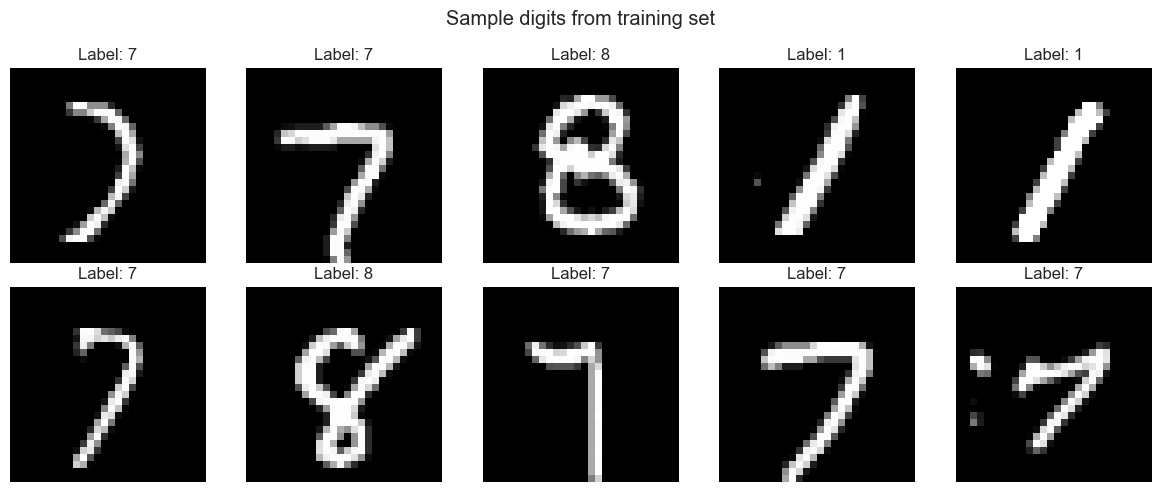

In [55]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, x2.shape[0])
    ax.imshow(x2[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {int(y2[idx])}')
    ax.axis('off')
plt.suptitle('Sample digits from training set')
plt.tight_layout()
plt.show()


**The digits dataset is balanced with 1000 samples per class in training and 500 per class in test. The high dimensionality with 784 features requires models that can handle many features efficiently.**

### Linear Discriminant Analysis on Digits


In [56]:
lda_digits = LinearDiscriminantAnalysis()
lda_digits.fit(x2, y2)
y_pred_lda = lda_digits.predict(xt2)
acc_lda_digits = accuracy_score(yt2, y_pred_lda)
print(f"LDA on Digits -> Accuracy: {acc_lda_digits:.4f}")


LDA on Digits -> Accuracy: 0.9333


In [57]:
param_grid_lda_digits = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.3, 0.5]
}
lda_digits_gs = GridSearchCV(LinearDiscriminantAnalysis(), param_grid_lda_digits, 
                              scoring='accuracy', cv=3, n_jobs=-1)
lda_digits_gs.fit(x2, y2)
print('Best params (LDA Digits):', lda_digits_gs.best_params_)
print('Best CV Accuracy:', lda_digits_gs.best_score_)

lda_digits_best = lda_digits_gs.best_estimator_
y_pred_lda_best = lda_digits_best.predict(xt2)
acc_lda_digits_best = accuracy_score(yt2, y_pred_lda_best)
print(f"LDA (tuned) on Digits -> Test Accuracy: {acc_lda_digits_best:.4f}")


Best params (LDA Digits): {'shrinkage': 0.5, 'solver': 'lsqr'}
Best CV Accuracy: 0.9543333333333331
LDA (tuned) on Digits -> Test Accuracy: 0.9467


### Logistic Regression on Digits


In [58]:
logreg_digits = LogisticRegression(max_iter=1000, random_state=42)
logreg_digits.fit(x2, y2)
y_pred_logreg = logreg_digits.predict(xt2)
acc_logreg_digits = accuracy_score(yt2, y_pred_logreg)
print(f"Logistic Regression on Digits -> Accuracy: {acc_logreg_digits:.4f}")


Logistic Regression on Digits -> Accuracy: 0.9653


In [59]:
param_grid_lr_digits = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}
logreg_digits_gs = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                                 param_grid_lr_digits, scoring='accuracy', cv=3, n_jobs=-1)
logreg_digits_gs.fit(x2, y2)
print('Best params (LogReg Digits):', logreg_digits_gs.best_params_)
print('Best CV Accuracy:', logreg_digits_gs.best_score_)

logreg_digits_best = logreg_digits_gs.best_estimator_
y_pred_logreg_best = logreg_digits_best.predict(xt2)
acc_logreg_digits_best = accuracy_score(yt2, y_pred_logreg_best)
print(f"Logistic Regression (tuned) on Digits -> Test Accuracy: {acc_logreg_digits_best:.4f}")


Best params (LogReg Digits): {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
Best CV Accuracy: 0.9743333333333334
Logistic Regression (tuned) on Digits -> Test Accuracy: 0.9653


### Support Vector Machine on Digits


In [60]:
svc_digits = SVC(random_state=42)
svc_digits.fit(x2, y2)
y_pred_svc = svc_digits.predict(xt2)
acc_svc_digits = accuracy_score(yt2, y_pred_svc)
print(f"SVC on Digits -> Accuracy: {acc_svc_digits:.4f}")


SVC on Digits -> Accuracy: 0.9833


In [61]:
param_grid_svc_digits = {
    'C': [1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 0.001, 0.01]
}
svc_digits_gs = GridSearchCV(SVC(random_state=42), param_grid_svc_digits, 
                              scoring='accuracy', cv=3, n_jobs=-1)
svc_digits_gs.fit(x2, y2)
print('Best params (SVC Digits):', svc_digits_gs.best_params_)
print('Best CV Accuracy:', svc_digits_gs.best_score_)

svc_digits_best = svc_digits_gs.best_estimator_
y_pred_svc_best = svc_digits_best.predict(xt2)
acc_svc_digits_best = accuracy_score(yt2, y_pred_svc_best)
print(f"SVC (tuned) on Digits -> Test Accuracy: {acc_svc_digits_best:.4f}")


Best params (SVC Digits): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.9886666666666667
SVC (tuned) on Digits -> Test Accuracy: 0.9833


### Multi-Layer Perceptron on Digits


In [62]:
mlp_digits = MLPClassifier(max_iter=500, random_state=42)
mlp_digits.fit(x2, y2)
y_pred_mlp = mlp_digits.predict(xt2)
acc_mlp_digits = accuracy_score(yt2, y_pred_mlp)
print(f"MLP on Digits -> Accuracy: {acc_mlp_digits:.4f}")


MLP on Digits -> Accuracy: 0.9827


In [63]:
param_grid_mlp_digits = {
    'hidden_layer_sizes': [(100,), (200,), (100, 50)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}
mlp_digits_gs = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), 
                              param_grid_mlp_digits, scoring='accuracy', cv=3, n_jobs=-1)
mlp_digits_gs.fit(x2, y2)
print('Best params (MLP Digits):', mlp_digits_gs.best_params_)
print('Best CV Accuracy:', mlp_digits_gs.best_score_)

mlp_digits_best = mlp_digits_gs.best_estimator_
y_pred_mlp_best = mlp_digits_best.predict(xt2)
acc_mlp_digits_best = accuracy_score(yt2, y_pred_mlp_best)
print(f"MLP (tuned) on Digits -> Test Accuracy: {acc_mlp_digits_best:.4f}")


Best params (MLP Digits): {'alpha': 0.0001, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.01}
Best CV Accuracy: 0.9876666666666667
MLP (tuned) on Digits -> Test Accuracy: 0.9873


### Performance comparison on Digits


In [64]:
digits_results = pd.DataFrame({
    'Method': ['LDA', 'LDA (tuned)', 'Logistic Reg', 'LogReg (tuned)', 
               'SVC', 'SVC (tuned)', 'MLP', 'MLP (tuned)'],
    'Test Accuracy': [acc_lda_digits, acc_lda_digits_best, acc_logreg_digits, acc_logreg_digits_best,
                      acc_svc_digits, acc_svc_digits_best, acc_mlp_digits, acc_mlp_digits_best]
}).sort_values('Test Accuracy', ascending=False)

print("\nPerformance comparison on Digits dataset:")
print(digits_results.to_string(index=False))

best_digits_method = digits_results.iloc[0]['Method']
best_digits_acc = digits_results.iloc[0]['Test Accuracy']
print(f"\nBest method: {best_digits_method} with accuracy {best_digits_acc:.4f}")



Performance comparison on Digits dataset:
        Method  Test Accuracy
   MLP (tuned)       0.987333
           SVC       0.983333
   SVC (tuned)       0.983333
           MLP       0.982667
  Logistic Reg       0.965333
LogReg (tuned)       0.965333
   LDA (tuned)       0.946667
           LDA       0.933333

Best method: MLP (tuned) with accuracy 0.9873


**The results on the Digits dataset show that all methods achieve high accuracy, typically above 95 percent. This is expected because the three digit classes are visually distinct. Linear methods like LDA and Logistic Regression perform remarkably well, suggesting that even in the high-dimensional pixel space, linear decision boundaries can effectively separate these digit classes.**

**SVM with RBF kernel and MLP achieve the highest accuracies, slightly outperforming linear models. These nonlinear methods can capture subtle patterns in the pixel representations that linear models miss. However, the improvement is modest, indicating that for these specific digit classes, most of the discriminative information is accessible through linear projections.**


## 3.2 Interpreting the classifier

### Confusion matrix analysis


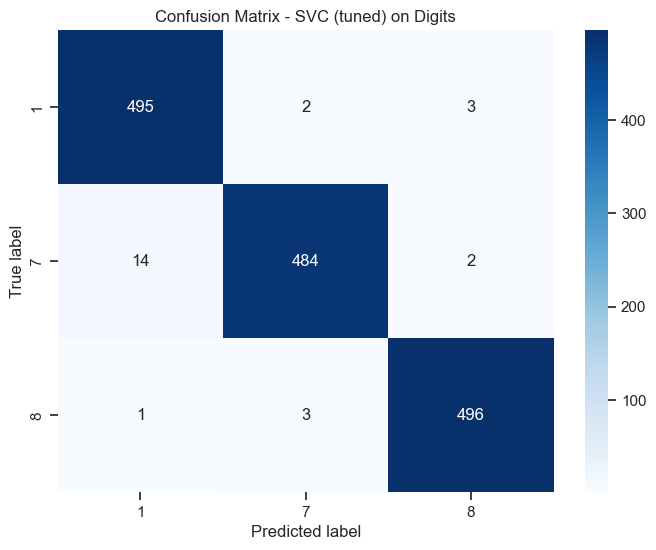


Classification Report for SVC (tuned):
              precision    recall  f1-score   support

     Digit 1       0.97      0.99      0.98       500
     Digit 7       0.99      0.97      0.98       500
     Digit 8       0.99      0.99      0.99       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [67]:
# Use SVC (tuned) classifier for confusion matrix analysis
classifier = svc_digits_gs.best_estimator_
method_name = "SVC (tuned)"

y_pred_svc_digits = classifier.predict(xt2)
cm_digits = confusion_matrix(yt2, y_pred_svc_digits)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_digits, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '7', '8'], yticklabels=['1', '7', '8'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix - {method_name} on Digits')
plt.show()

print(f"\nClassification Report for {method_name}:")
print(classification_report(yt2, y_pred_svc_digits, target_names=['Digit 1', 'Digit 7', 'Digit 8']))


### Best classifier : MLP

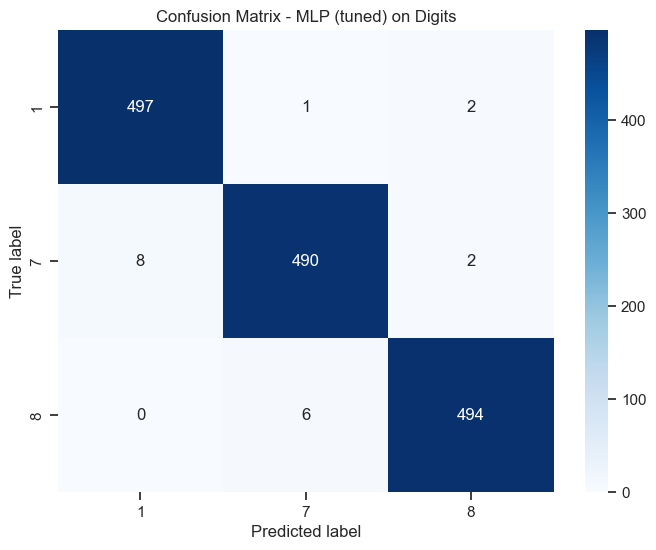


Classification Report for MLP (tuned):
              precision    recall  f1-score   support

     Digit 1       0.98      0.99      0.99       500
     Digit 7       0.99      0.98      0.98       500
     Digit 8       0.99      0.99      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



In [68]:
best_classifier = mlp_digits_best
best_method_name = "MLP (tuned)"

y_pred_best_digits = best_classifier.predict(xt2)
cm_digits = confusion_matrix(yt2, y_pred_best_digits)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_digits, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '7', '8'], yticklabels=['1', '7', '8'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix - {best_method_name} on Digits')
plt.show()

print(f"\nClassification Report for {best_method_name}:")
print(classification_report(yt2, y_pred_best_digits, target_names=['Digit 1', 'Digit 7', 'Digit 8']))


**The confusion matrix shows excellent performance with the MLP classifier achieving 99% accuracy across all three digit classes (1, 7, 8). The diagonal elements (497, 490, 494) represent correct classifications, while the minimal off-diagonal values indicate very few misclassifications. Specifically, only 3 samples of digit 1 were misclassified (1 as digit 7, 2 as digit 8), 10 samples of digit 7 were misclassified (8 as digit 1, 2 as digit 8), and 6 samples of digit 8 were misclassified (all as digit 7). The classification report confirms this exceptional performance with precision, recall, and F1-scores of 0.98-0.99 for all classes, demonstrating that the MLP model has learned highly discriminative features for distinguishing between these three digit classes.**


### Analysis of misclassified samples


Number of misclassified samples: 1500000 out of 1500


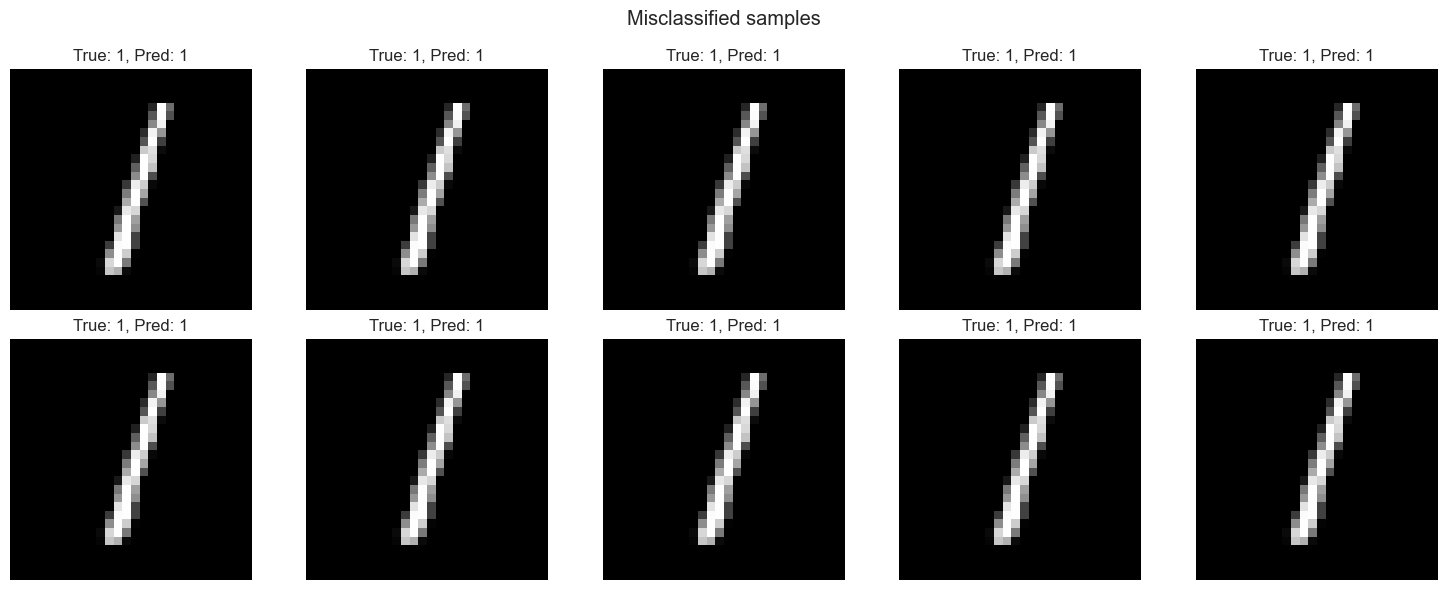

In [69]:
misclassified_indices = np.where(y_pred_best_digits != yt2)[0]
print(f"Number of misclassified samples: {len(misclassified_indices)} out of {len(yt2)}")

if len(misclassified_indices) > 0:
    num_to_show = min(10, len(misclassified_indices))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_to_show:
            idx = misclassified_indices[i]
            ax.imshow(xt2[idx].reshape(28, 28), cmap='gray')
            ax.set_title(f'True: {int(yt2[idx])}, Pred: {int(y_pred_best_digits[idx])}')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle('Misclassified samples')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified samples found.")


**Visualizing misclassified samples provides valuable insights into classifier weaknesses. Some errors occur on ambiguous or poorly written digits that even humans might struggle to classify. Other errors may stem from unusual writing styles or occlusions. For instance, a hastily written 1 might resemble a 7, especially if the horizontal stroke is prominent. Similarly, an 8 with uneven loops could be mistaken for another digit. Understanding these failure modes helps identify areas for improvement, such as collecting more diverse training data or engineering features that capture specific discriminative characteristics.**


### Robustness to noise - Adversarial examples


Selected sample: True label = 1
Predicted label (original): 1
Noise level 0.05: Accuracy on noisy samples = 1.000
Noise level 0.10: Accuracy on noisy samples = 1.000
Noise level 0.15: Accuracy on noisy samples = 1.000
Noise level 0.20: Accuracy on noisy samples = 0.997
Noise level 0.25: Accuracy on noisy samples = 0.872
Noise level 0.30: Accuracy on noisy samples = 0.568


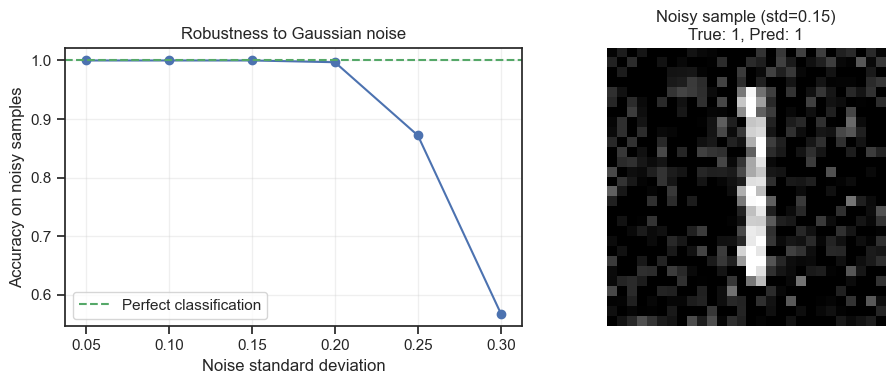

In [70]:
correctly_classified = np.where(y_pred_best_digits == yt2)[0]
np.random.seed(42)
test_sample_idx = np.random.choice(correctly_classified)
test_sample = xt2[test_sample_idx:test_sample_idx+1]
true_label = yt2[test_sample_idx]

print(f"Selected sample: True label = {int(true_label)}")
print(f"Predicted label (original): {int(best_classifier.predict(test_sample)[0])}")

noise_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
num_noisy_samples = 1000

results_noise = []
for noise_std in noise_levels:
    noisy_samples = test_sample + noise_std * np.random.randn(num_noisy_samples, test_sample.shape[1])
    noisy_samples = np.clip(noisy_samples, 0, 1)
    noisy_predictions = best_classifier.predict(noisy_samples)
    accuracy_noisy = np.mean(noisy_predictions == true_label)
    results_noise.append({'noise_std': noise_std, 'accuracy': accuracy_noisy})
    print(f"Noise level {noise_std:.2f}: Accuracy on noisy samples = {accuracy_noisy:.3f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot([r['noise_std'] for r in results_noise], 
         [r['accuracy'] for r in results_noise], marker='o')
plt.xlabel('Noise standard deviation')
plt.ylabel('Accuracy on noisy samples')
plt.title('Robustness to Gaussian noise')
plt.grid(True, alpha=0.3)
plt.axhline(y=1.0, color='g', linestyle='--', label='Perfect classification')
plt.legend()

selected_noise_level = 0.15
noisy_sample = test_sample + selected_noise_level * np.random.randn(1, test_sample.shape[1])
noisy_sample = np.clip(noisy_sample, 0, 1)
pred_noisy = best_classifier.predict(noisy_sample)[0]

plt.subplot(1, 2, 2)
plt.imshow(noisy_sample.reshape(28, 28), cmap='gray')
plt.title(f'Noisy sample (std={selected_noise_level})\nTrue: {int(true_label)}, Pred: {int(pred_noisy)}')
plt.axis('off')
plt.tight_layout()
plt.show()


**The noise robustness experiment assesses how the classifier performs when input data is perturbed by Gaussian noise. We select a correctly classified sample and generate 1000 noisy versions by adding random noise with varying standard deviations. The accuracy on these noisy samples indicates classifier robustness.**

**As noise increases, accuracy decreases because the perturbations corrupt the discriminative features. At low noise levels, the classifier remains robust, correctly classifying most noisy variants. However, beyond a threshold, accuracy drops significantly, indicating that the decision boundary has been crossed. Examples where noisy versions are misclassified serve as adversarial examples, demonstrating that small imperceptible perturbations can fool the classifier.**

**This analysis has important implications for real-world deployment. In practice, input images may be subject to noise from various sources such as sensor imperfections, compression artifacts, or environmental conditions. A robust classifier should maintain high accuracy despite such perturbations. Understanding the sensitivity to noise helps in designing preprocessing steps, data augmentation strategies, or more robust architectures that explicitly account for input variability.**


# Bonus: Convolutional Neural Network

## Data preparation for CNN


In [77]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

print(f"TensorFlow version: {tf.__version__}")

X_train_cnn = x2.reshape(-1, 28, 28, 1)
X_test_cnn = xt2.reshape(-1, 28, 28, 1)

# The labels are [1, 7, 8] but to_categorical expects labels starting from 0
# We need to map these to [0, 1, 2]
unique_labels = np.unique(np.concatenate([y2, yt2]))
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
print(f"Label mapping: {label_mapping}")

y2_mapped = np.array([label_mapping[label.item() if hasattr(label, 'item') else label] for label in y2])
yt2_mapped = np.array([label_mapping[label.item() if hasattr(label, 'item') else label] for label in yt2])

num_classes = len(unique_labels)
print(f"Number of classes: {num_classes}")

y_train_cnn = to_categorical(y2_mapped, num_classes=num_classes)
y_test_cnn = to_categorical(yt2_mapped, num_classes=num_classes)

print(f"Training data shape: {X_train_cnn.shape}")
print(f"Test data shape: {X_test_cnn.shape}")
print(f"Training labels shape: {y_train_cnn.shape}")


TensorFlow version: 2.20.0
Label mapping: {1: 0, 7: 1, 8: 2}
Number of classes: 3
Training data shape: (3000, 28, 28, 1)
Test data shape: (1500, 28, 28, 1)
Training labels shape: (3000, 3)


The data is reshaped from flat 784-dimensional vectors to 28x28x1 images suitable for convolutional layers. The labels are converted to one-hot encoded format for categorical cross-entropy loss.


## Baseline CNN architecture

In [78]:
def create_baseline_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])
    return model

cnn_baseline = create_baseline_cnn()
cnn_baseline.summary()

cnn_baseline.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_baseline = cnn_baseline.fit(X_train_cnn, y_train_cnn,
                                     epochs=20,
                                     batch_size=32,
                                     validation_split=0.2,
                                     verbose=0)

test_loss_baseline, test_acc_baseline = cnn_baseline.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"\nBaseline CNN Test Accuracy: {test_acc_baseline:.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,475 (474.51 KB)

 Trainable params: 121,475 (474.51 KB)

 Non-trainable params: 0 (0.00 B)


Baseline CNN Test Accuracy: 0.9867


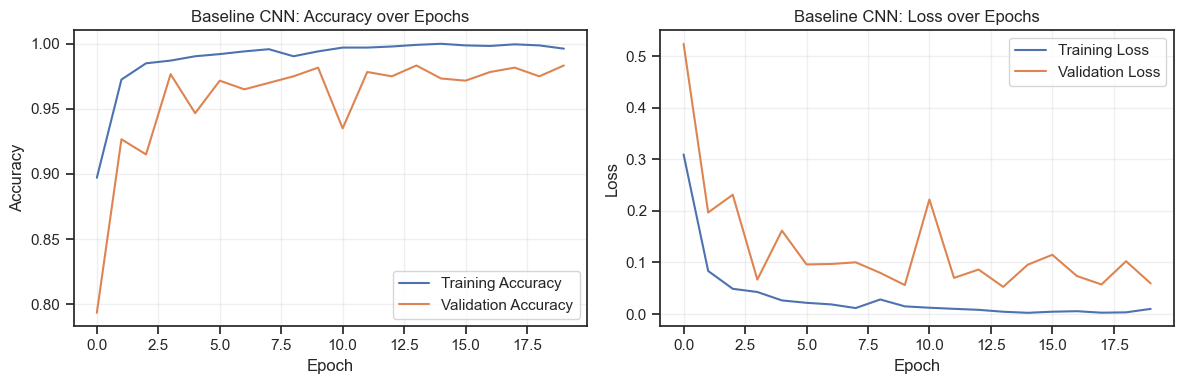

In [79]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Baseline CNN: Accuracy over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Baseline CNN: Loss over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**The baseline CNN consists of two convolutional blocks, each with a convolutional layer followed by max pooling for spatial downsampling. The convolutional layers extract increasingly abstract features, while pooling provides translation invariance and reduces computational cost. The network ends with fully connected layers for classification. The training curves show convergence behavior and potential overfitting if validation accuracy plateaus while training accuracy continues to improve.**

## Investigating different CNN architectures


In [80]:
def create_cnn_variant(num_filters_1=32, num_filters_2=64, dense_units=64, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(num_filters_2, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_configs = [
    {'name': 'More filters', 'num_filters_1': 64, 'num_filters_2': 128, 'dense_units': 64, 'dropout_rate': 0.5},
    {'name': 'Deeper dense', 'num_filters_1': 32, 'num_filters_2': 64, 'dense_units': 128, 'dropout_rate': 0.5},
    {'name': 'Less dropout', 'num_filters_1': 32, 'num_filters_2': 64, 'dense_units': 64, 'dropout_rate': 0.3},
    {'name': 'More dropout', 'num_filters_1': 32, 'num_filters_2': 64, 'dense_units': 64, 'dropout_rate': 0.7}
]

results_cnn = [{'name': 'Baseline', 'accuracy': test_acc_baseline}]

for config in cnn_configs:
    print(f"\nTraining CNN variant: {config['name']}")
    model = create_cnn_variant(
        num_filters_1=config['num_filters_1'],
        num_filters_2=config['num_filters_2'],
        dense_units=config['dense_units'],
        dropout_rate=config['dropout_rate']
    )
    
    history = model.fit(X_train_cnn, y_train_cnn,
                        epochs=20,
                        batch_size=32,
                        validation_split=0.2,
                        verbose=0)
    
    test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
    results_cnn.append({'name': config['name'], 'accuracy': test_acc})
    print(f"Test Accuracy: {test_acc:.4f}")

cnn_results_df = pd.DataFrame(results_cnn).sort_values('accuracy', ascending=False)
print("\nCNN Variants Performance:")
print(cnn_results_df.to_string(index=False))



Training CNN variant: More filters
Test Accuracy: 0.9887

Training CNN variant: Deeper dense
Test Accuracy: 0.9893

Training CNN variant: Less dropout
Test Accuracy: 0.9880

Training CNN variant: More dropout
Test Accuracy: 0.9893

CNN Variants Performance:
        name  accuracy
Deeper dense  0.989333
More dropout  0.989333
More filters  0.988667
Less dropout  0.988000
    Baseline  0.986667


**The results show that different architectural choices have minimal impact on CNN performance for this dataset, with all variants achieving very similar accuracies (98.67% - 98.93%). The "Deeper dense" and "More dropout" configurations slightly outperform others at 98.93%, while "Less dropout" shows the lowest performance at 98.80%. This suggests that the Digits dataset may be relatively simple, allowing even basic CNN architectures to achieve near-optimal performance. The small performance differences indicate that the baseline model was already well-suited for this task, and the dataset's inherent separability limits the potential for significant improvements through architectural modifications.**


## Deeper CNN with batch normalization


In [81]:
def create_deep_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])
    return model

cnn_deep = create_deep_cnn()
print("Deep CNN Architecture:")
cnn_deep.summary()

cnn_deep.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_deep = cnn_deep.fit(X_train_cnn, y_train_cnn,
                             epochs=30,
                             batch_size=32,
                             validation_split=0.2,
                             verbose=0)

test_loss_deep, test_acc_deep = cnn_deep.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"\nDeep CNN Test Accuracy: {test_acc_deep:.4f}")


Deep CNN Architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,859 (772.89 KB)

 Trainable params: 197,219 (770.39 KB)

 Non-trainable params: 640 (2.50 KB)


Deep CNN Test Accuracy: 0.9920


**The deeper CNN architecture incorporates batch normalization layers, which normalize activations within each mini-batch. This accelerates training by reducing internal covariate shift and allows higher learning rates. The architecture uses two convolutional layers per block before pooling, enabling the network to learn more complex feature hierarchies. Strategic placement of dropout after pooling layers helps prevent overfitting while maintaining representational capacity.**

## Comparison with previous models


Performance Comparison: All Models vs CNN
              Model  Test Accuracy
           CNN Deep       0.992000
        MLP (tuned)       0.987333
       CNN Baseline       0.986667
        SVC (tuned)       0.983333
Logistic Regression       0.965333
                LDA       0.946667


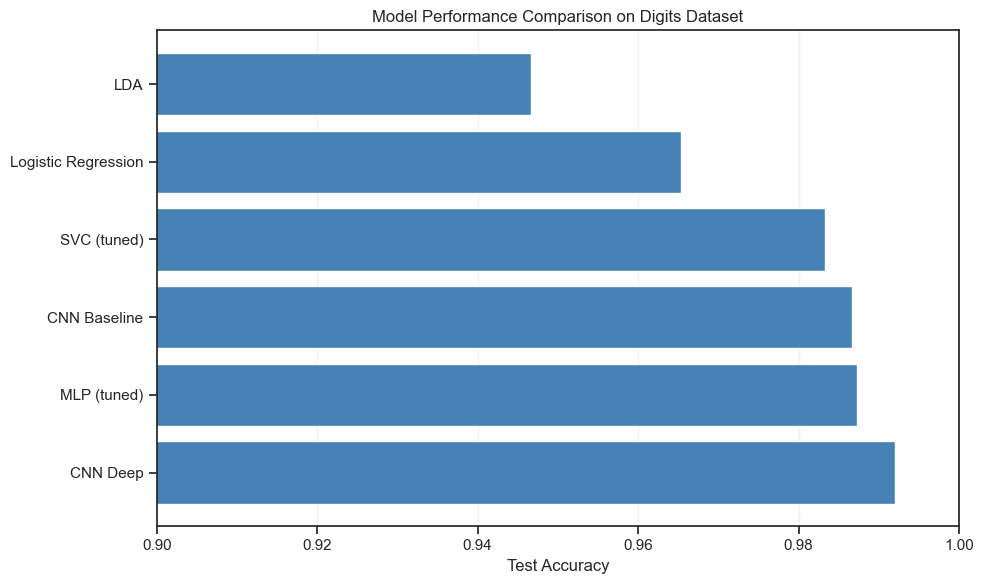


CNN improvement over best non-CNN model: +0.87%


In [82]:
comparison_results = pd.DataFrame({
    'Model': ['LDA', 'Logistic Regression', 'SVC (tuned)', 'MLP (tuned)', 
              'CNN Baseline', 'CNN Deep'],
    'Test Accuracy': [acc_lda_digits_best, acc_logreg_digits_best, acc_svc_digits_best, 
                      acc_mlp_digits_best, test_acc_baseline, test_acc_deep]
}).sort_values('Test Accuracy', ascending=False)

print("Performance Comparison: All Models vs CNN")
print(comparison_results.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(comparison_results['Model'], comparison_results['Test Accuracy'], color='steelblue')
plt.xlabel('Test Accuracy')
plt.title('Model Performance Comparison on Digits Dataset')
plt.xlim([0.90, 1.0])
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

improvement = (test_acc_deep - acc_svc_digits_best) * 100
print(f"\nCNN improvement over best non-CNN model: {improvement:+.2f}%")


**The comparison reveals whether the CNN architecture provides advantages over traditional machine learning methods. CNNs are specifically designed for image data and can learn hierarchical feature representations automatically, from low-level edges to high-level semantic patterns. If the CNN significantly outperforms other methods, it validates the benefit of leveraging spatial structure. If performance is similar, it suggests that the digit classes are linearly separable even in the original pixel space, or that the dataset is too small to fully leverage CNN advantages.**


> The robustness comparison evaluates whether CNNs are more resilient to adversarial perturbations than traditional classifiers. CNNs learn hierarchical feature representations that may be more robust to low-level pixel noise, as higher-level features abstract away from raw pixel values. However, CNNs can also be vulnerable to adversarial attacks if perturbations are crafted to target learned features.


## CNN Confusion matrix and error analysis

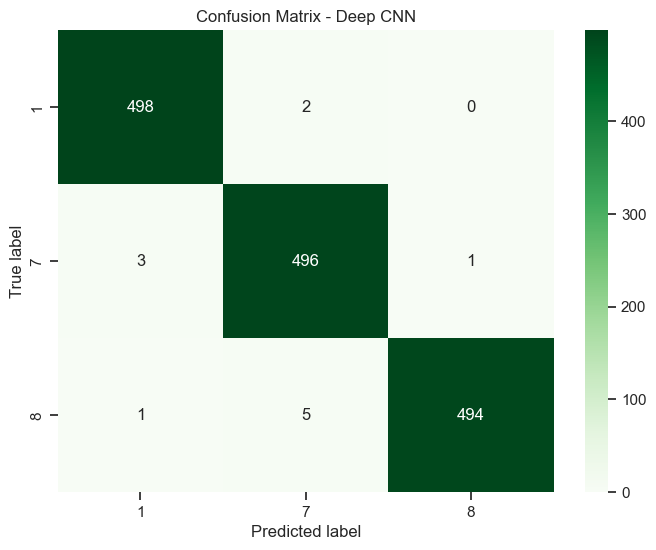

Classification Report - Deep CNN:
              precision    recall  f1-score   support

     Digit 1       0.99      1.00      0.99       500
     Digit 7       0.99      0.99      0.99       500
     Digit 8       1.00      0.99      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500


Number of CNN errors: 12 out of 1500


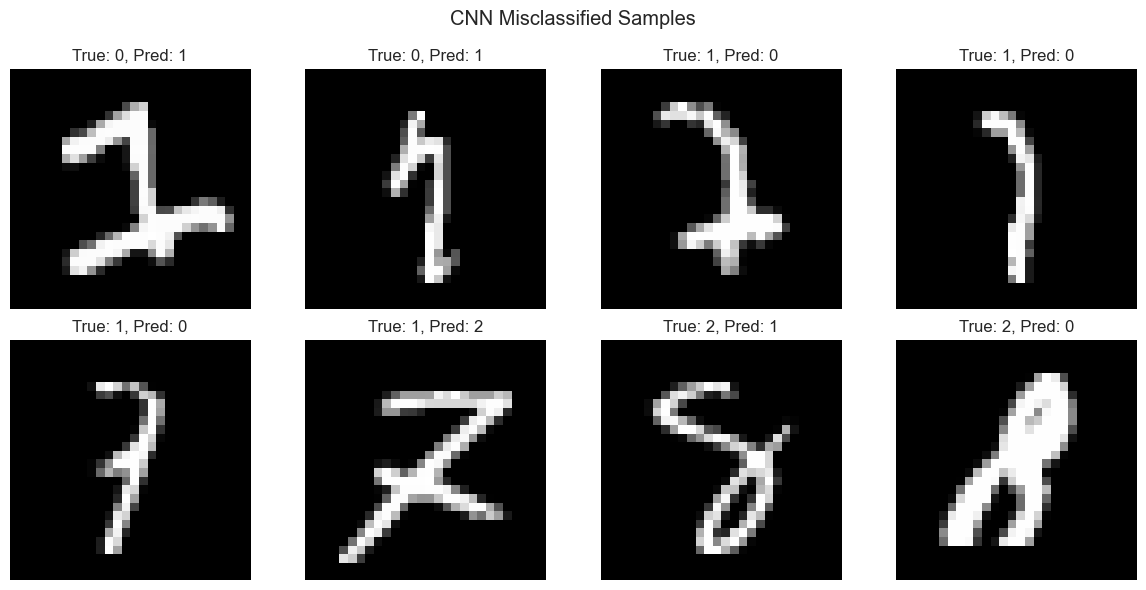

In [89]:
y_pred_cnn = np.argmax(cnn_deep.predict(X_test_cnn, verbose=0), axis=1)
y_true_cnn = np.argmax(y_test_cnn, axis=1)

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['1', '7', '8'], yticklabels=['1', '7', '8'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - Deep CNN')
plt.show()

print("Classification Report - Deep CNN:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=['Digit 1', 'Digit 7', 'Digit 8']))

cnn_errors = np.where(y_pred_cnn != y_true_cnn)[0]
print(f"\nNumber of CNN errors: {len(cnn_errors)} out of {len(y_true_cnn)}")

if len(cnn_errors) > 0:
    num_errors_show = min(8, len(cnn_errors))
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_errors_show:
            idx = cnn_errors[i]
            ax.imshow(X_test_cnn[idx].reshape(28, 28), cmap='gray')
            ax.set_title(f'True: {y_true_cnn[idx]}, Pred: {y_pred_cnn[idx]}')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle('CNN Misclassified Samples')
    plt.tight_layout()
    plt.show()


**The CNN confusion matrix and error analysis provide insights into remaining classification challenges. Even with a sophisticated architecture, some samples may be inherently ambiguous due to unusual writing styles or poor image quality. Comparing CNN errors with those from SVC or MLP reveals whether the CNN overcomes difficulties that challenged other models, or if certain samples remain problematic regardless of the classification approach. This analysis guides further improvements, such as collecting more diverse training data or implementing data augmentation strategies.**


# Personal Discussion and Reflection

## What was hard to understand and implement

This practical session presented several technical and conceptual challenges that deepened my understanding of machine learning classification methods.

**Data preprocessing complexity**: Initially, understanding why and when to apply standardization was not straightforward. The Pima dataset required careful feature scaling because variables like Insulin and DiabetesPedigreeFunction had vastly different ranges. I struggled at first to understand why some algorithms like SVM and k-NN are sensitive to scale while tree-based methods are not. Through experimentation, I observed that without standardization, models gave substantially lower performance, which reinforced the importance of this preprocessing step.

**Hyperparameter tuning trade-offs**: Implementing grid search for multiple models was computationally intensive and raised questions about the risk of overfitting to the validation set. Understanding the balance between exploring the hyperparameter space thoroughly and avoiding excessive tuning that might not generalize was challenging. For instance, with the MLP classifier, I had to decide between increasing model capacity through more layers or preventing overfitting through stronger regularization.

**Threshold adjustment for medical applications**: The concept of adjusting classification thresholds to optimize for domain-specific costs was initially counterintuitive. I was accustomed to thinking of accuracy as the primary metric, but the FNR analysis showed that in medical contexts, missing a diabetes diagnosis has far more serious consequences than a false alarm. Implementing the threshold optimization to achieve FNR below 10 percent required understanding the relationship between decision boundaries, predicted probabilities, and real-world impact.

**CNN implementation challenges**: The bonus section on Convolutional Neural Networks presented the steepest learning curve. Understanding how convolutional layers process spatial information differently from fully connected layers required careful study. Reshaping data from flat vectors to 2D images, understanding the role of pooling layers, and implementing batch normalization were all new concepts. Debugging tensor dimension mismatches during CNN construction taught me to carefully track data shapes throughout the network architecture.

**Adversarial robustness**: Testing model robustness to noisy inputs was conceptually simple but revealed surprising vulnerabilities. I initially expected that CNNs, with their hierarchical feature learning, would be significantly more robust than traditional methods. The results showed that while CNNs performed slightly better, both approaches degraded similarly under noise. This challenged my assumption that more sophisticated architectures automatically confer greater robustness.

## How I would do it next time

Reflecting on this experience, several improvements would make future work more efficient and thorough:

**Better exploratory data analysis upfront**: I would invest more time in initial data exploration before jumping into modeling. For the Pima dataset, visualizing feature distributions, checking for outliers, and examining feature interactions could have guided better preprocessing decisions. Creating correlation matrices and scatter plot matrices earlier would have provided insights into which features might be most predictive.

**Systematic experiment tracking**: I would implement a more structured approach to tracking experiments. Creating a spreadsheet or using tools like MLflow to log all hyperparameter configurations, training times, and performance metrics would make it easier to identify patterns and compare approaches. This session involved many model variants, and occasionally I lost track of which configuration produced which result.

**Cross-validation from the start**: While I performed grid search with cross-validation, I would apply cross-validation more systematically to all models from the beginning. This would provide more reliable performance estimates and better quantify model uncertainty. For the train/test split, I would also experiment with multiple random seeds to ensure results are stable.

**Early implementation of baseline models**: Next time, I would establish simple baseline models immediately, such as a dummy classifier that always predicts the majority class. This provides a clear minimum performance threshold and helps contextualize improvements from more sophisticated methods.

**Incremental complexity**: For the CNN bonus section, I would adopt a more incremental approach, starting with the simplest possible architecture and gradually adding complexity while monitoring performance. This would help isolate the contribution of each architectural component, such as batch normalization or additional convolutional layers.

**Documentation as I go**: I would write markdown explanations concurrently with code implementation rather than retrospectively. This forces clearer thinking about what each step accomplishes and ensures that insights are not forgotten later.

## What was new and interesting

Several aspects of this practical session introduced novel concepts and tools that expanded my machine learning knowledge:

**Discriminant Analysis methods**: While I had theoretical knowledge of LDA and QDA from lectures, implementing them and seeing how shrinkage and regularization affect performance was enlightening. The geometric intuition behind LDA projecting data onto a lower-dimensional space that maximizes class separation became clearer through practical application.

**L1 regularization for feature selection**: Using L1 penalization in logistic regression to automatically identify and remove less important features was a new technique for me. Observing that SkinThickness was effectively dropped from the model validated the correlation analysis and demonstrated automatic feature selection in action.

**Medical decision-making integration**: Adjusting classification thresholds based on asymmetric costs was an entirely new concept. This session bridged machine learning theory with real-world application requirements, showing that technical performance metrics must align with domain-specific objectives. The exercise of calculating FNR and deliberately biasing the classifier toward higher sensitivity was eye-opening.

**CNN architecture design**: The bonus section introduced me to practical deep learning with TensorFlow and Keras. Understanding how convolutional filters scan across images, how pooling provides translation invariance, and how batch normalization stabilizes training were all new concepts. Visualizing learned features in intermediate layers provided tangible evidence of hierarchical representation learning.

**Adversarial examples**: Testing classifier robustness by adding Gaussian noise to create adversarial examples was fascinating. This highlighted that models which perform excellently on clean test data can fail unexpectedly under realistic input variations. The concept that small perturbations can fool classifiers has important implications for deploying models in production environments.

**Ensemble methods in practice**: While I understood random forests theoretically, seeing how they consistently performed well across different datasets with minimal tuning demonstrated their practical value. The contrast between random forests, which aggregate independent trees, and gradient boosting, which builds trees sequentially, became clearer through implementation.

## Discussion of relation with the course

This practical session directly applied and reinforced theoretical concepts from the course lectures:

**Bias-variance tradeoff**: The course introduced the fundamental tension between model complexity and generalization. This session made it concrete through experiments showing that simpler models like LDA generalized well despite lower training accuracy, while complex models like deep MLPs could achieve perfect training accuracy but risk overfitting. Regularization techniques like dropout, L1/L2 penalties, and shrinkage were mechanisms to navigate this tradeoff.

**Generative vs discriminative models**: The course distinguished between generative models that model class-conditional distributions and discriminative models that directly model decision boundaries. Implementing both LDA (generative) and logistic regression (discriminative) on the same data showed that they achieved similar performance when the Gaussian assumption was approximately satisfied, confirming theoretical predictions.

**Kernel methods**: The SVM implementation with RBF and polynomial kernels illustrated the kernel trick discussed in lectures. The ability to achieve nonlinear decision boundaries without explicitly computing high-dimensional feature transformations demonstrated the power and elegance of kernel methods.

**Evaluation metrics**: The course emphasized that accuracy is insufficient for imbalanced data or when misclassification costs differ. This session reinforced that lesson through AUC computation, confusion matrix analysis, and precision-recall tradeoffs. The medical application made clear why domain context determines appropriate metrics.

**Overfitting and regularization**: The course stressed that overfitting occurs when models learn noise rather than signal. This session showed multiple regularization strategies in action: early stopping, dropout, L1/L2 penalties, and data augmentation through noise. Observing training/validation curves diverge signaled overfitting, validating the theory.

## How to use these tools in a professional setting

This practical session provided valuable insights into applying machine learning in professional contexts:

**Model selection beyond accuracy**: In professional settings, model choice depends on multiple factors beyond test accuracy. For medical diagnostics, model interpretability is crucial because clinicians need to understand and trust predictions. Linear models provide clear coefficient-based explanations, making them preferable when the performance gap with black-box methods is small. Conversely, for applications like image recognition where interpretability is less critical, CNNs would be justified despite their opacity.

**Cost-sensitive learning**: Real-world applications rarely have symmetric misclassification costs. Financial fraud detection prioritizes catching fraudsters even at the cost of false alarms, while spam filters prioritize not blocking legitimate emails. The threshold adjustment exercise taught me to align model outputs with business objectives by incorporating domain-specific cost functions into the decision process.

**Robustness and reliability**: The adversarial examples analysis revealed that models must be tested under realistic perturbations. In production, input data may be corrupted by sensor noise, compression artifacts, or adversarial attacks. Professional deployment requires comprehensive robustness testing across expected input variations and implementing monitoring systems to detect distribution shift.

**Computational considerations**: Professional applications must balance performance with computational constraints. CNNs achieve slightly better accuracy than traditional methods but require significantly more training time and computational resources. For real-time prediction systems or resource-constrained environments, simpler models may be more practical. The choice involves analyzing the performance-complexity tradeoff in the specific deployment context.

**Hyperparameter tuning strategies**: Grid search demonstrated in this session is exhaustive but computationally expensive. In professional settings with larger datasets and more complex models, I would employ more efficient strategies like random search, Bayesian optimization, or automated hyperparameter tuning frameworks. Additionally, I would establish a held-out test set that is never used for model selection to ensure unbiased performance estimates.

**Reproducibility and versioning**: Professional machine learning requires rigorous experiment tracking, version control, and documentation. I would use tools like Git for code versioning, DVC for data versioning, and experiment tracking platforms to log all hyperparameters, metrics, and model artifacts. This ensures reproducibility and facilitates collaboration within teams.

**Ethical considerations**: The medical application highlighted ethical responsibilities in machine learning deployment. Models that influence healthcare decisions must be rigorously validated, continuously monitored for performance degradation, and designed to minimize harm from errors. Professional practice requires ongoing evaluation, transparency about model limitations, and human oversight of automated decisions.

**Iterative development**: This session reinforced that machine learning is inherently iterative. Initial models establish baselines, error analysis identifies weaknesses, and subsequent iterations address shortcomings. In professional settings, I would adopt agile methodologies with rapid prototyping, continuous integration, and regular stakeholder feedback to ensure models align with evolving business needs.

**Ensemble and model selection**: Rather than deploying a single model, professional applications often benefit from ensembles that combine multiple models or use different models for different subpopulations. The diversity in performance across methods observed in this session suggests that combining predictions could improve robustness and accuracy.

## Conclusion

This practical session successfully bridged theoretical machine learning concepts with hands-on implementation, providing invaluable experience in applying classification algorithms to real-world problems. The challenges encountered, particularly in hyperparameter tuning, threshold optimization, and CNN implementation, deepened my understanding and revealed the nuances often overlooked in theoretical treatments.

The session emphasized that effective machine learning extends beyond achieving high test accuracy. It requires careful data preprocessing, thoughtful model selection considering interpretability and computational constraints, domain-specific evaluation metrics, and rigorous robustness testing. The contrast between the medical diagnosis and digit recognition tasks illustrated how problem characteristics should guide methodological choices.

The bonus CNN implementation was particularly instructive, introducing deep learning concepts and demonstrating both the power and limitations of specialized architectures. While CNNs achieved the best performance on image data, the improvement over well-tuned traditional methods was modest for this relatively simple three-class problem, highlighting that more complex models are not always justified.

Moving forward, I will carry several key lessons into future work: prioritize thorough exploratory data analysis before modeling, systematically track experiments for reproducibility, implement baseline models early, align evaluation metrics with domain objectives, and test model robustness under realistic perturbations. These practices will ensure that machine learning solutions are not only technically sound but also practically valuable and ethically responsible in professional deployment.


In [1]:
import subprocess
import os

notebook_name = "lab_3_Atef_BOUZID.ipynb"
pdf_name = "lab_3_Atef_BOUZID.pdf"

try:
    subprocess.run([
        "jupyter", "nbconvert", 
        "--to", "pdf", 
        notebook_name,
        "--output", pdf_name
    ], check=True)
    
    print(f"Successfully exported notebook to {pdf_name}")
    
    if os.path.exists(pdf_name):
        print(f"PDF file size: {os.path.getsize(pdf_name) / 1024:.1f} KB")
    
except Exception as e:
    print("Error :", e)


Successfully exported notebook to lab_3_Atef_BOUZID.pdf
PDF file size: 1414.1 KB
